In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

data = pd.read_csv('../cloud-data/bus_data.csv')
data.head()

id  name                   type  calculatedCourse   routeName   created  \
0   4855  4131            Transit Bus        212.735226    LX Route  02:23 PM   
1   4859  4177            Transit Bus        128.232575    LX Route  02:23 PM   
2   4873  4191            Transit Bus        240.802514     B Route  02:23 PM   
3   4876  4194            Transit Bus        299.246496     B Route  02:23 PM   
4  17624  4002  Heavy Duty Transit LF        226.694476  REXB Route  02:23 PM   

   longitude   latitude  paxLoad  totalCap  more  tripId  deviceId  \
0 -74.433571  40.519749        0        67   101     NaN    402213   
1 -74.436304  40.524327       27        67   102     NaN    402325   
2 -74.457712  40.523463        8        67   101     NaN    402329   
3 -74.438946  40.521624        4        67   102     NaN    402330   
4 -74.438830  40.483538        2        68   102     NaN    402643   

   routeBlockId            timestamp  speed  
0        111417  2024-10-31 18:24:00    NaN  
1        111417  2024-10-31 18:24:00    NaN  
2        113278  2024-10-31 18:24:00    NaN  
3        113250  2024-10-31 18:24:00    NaN  
4        112511  2024-10-31 18:24:00    NaN

In [3]:
# convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
# shift all timestamps 6 hrs back
data['timestamp'] = data['timestamp'] - pd.Timedelta(hours=6)
try:
    data.drop(['speed', 'outOfService', 'tripId', 'outdated'], axis=1, inplace=True)
except:
    data.drop(['speed', 'tripId'], axis=1, inplace=True)
data['load'] = data['paxLoad'] / data['totalCap']
# only use the latitude and longitude columns between certain values
data = data[(data['latitude'] > 40.4) & (data['latitude'] < 40.53)]
data = data[(data['longitude'] > -74.5) & (data['longitude'] < -74.3)]
data.head()

id  name                   type  calculatedCourse   routeName   created  \
0   4855  4131            Transit Bus        212.735226    LX Route  02:23 PM   
1   4859  4177            Transit Bus        128.232575    LX Route  02:23 PM   
2   4873  4191            Transit Bus        240.802514     B Route  02:23 PM   
3   4876  4194            Transit Bus        299.246496     B Route  02:23 PM   
4  17624  4002  Heavy Duty Transit LF        226.694476  REXB Route  02:23 PM   

   longitude   latitude  paxLoad  totalCap  more  deviceId  routeBlockId  \
0 -74.433571  40.519749        0        67   101    402213        111417   
1 -74.436304  40.524327       27        67   102    402325        111417   
2 -74.457712  40.523463        8        67   101    402329        113278   
3 -74.438946  40.521624        4        67   102    402330        113250   
4 -74.438830  40.483538        2        68   102    402643        112511   

            timestamp      load  
0 2024-10-31 12:24:00  0.000000  
1 2024-10-31 12:24:00  0.402985  
2 2024-10-31 12:24:00  0.119403  
3 2024-10-31 12:24:00  0.059701  
4 2024-10-31 12:24:00  0.029412

C:\Users\akash\AppData\Local\Temp\ipykernel_2972\2932592385.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(timestamps, load, c=colors, cmap=cmap, edgecolor='k', s=50)  # Use a scatter plot for visual clarity


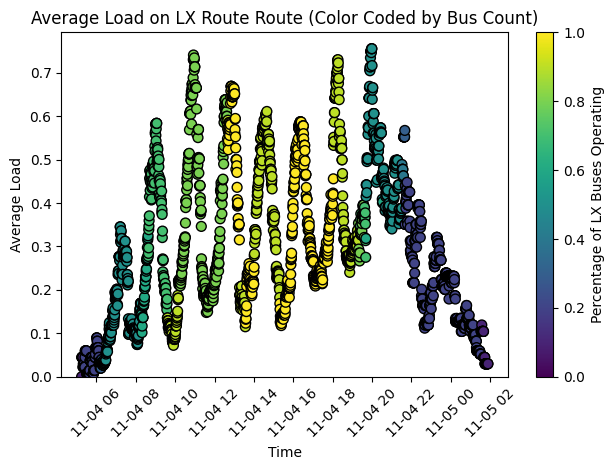

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Get unique timestamps
timestamps = data['timestamp'].dt.floor('s').unique()

# Data for the number of buses running (as before)
route_name = 'LX Route'
data_route = data[data['routeName'] == route_name]

# only look at data on 11/04 to 11/05 3:00
data_route = data_route[(data_route['timestamp'] > '2024-11-04') & (data_route['timestamp'] < '2024-11-05 03:00:00')]

# Calculate bus count at each timestamp
bus_count = []
for timestamp in timestamps:
    bus_count.append(data_route[data_route['timestamp'].dt.floor('s') == timestamp]['deviceId'].nunique())

# Normalize bus count for color mapping
norm = mcolors.Normalize(vmin=min(bus_count), vmax=max(bus_count))
cmap = plt.cm.viridis  # Use a colormap like 'viridis' or 'plasma'
colors = cmap(norm(bus_count))

# Data for average load (as before)
load = []
for timestamp in timestamps:
    load.append(data_route[data_route['timestamp'].dt.floor('s') == timestamp]['load'].mean())

# Create a scatter plot with colors based on bus count
fig, ax = plt.subplots()  # Explicitly create a figure and Axes
scatter = ax.scatter(timestamps, load, c=colors, cmap=cmap, edgecolor='k', s=50)  # Use a scatter plot for visual clarity

ax.set_title(f'Average Load on {route_name} Route (Color Coded by Bus Count)')
ax.set_xlabel('Time')
ax.set_ylabel('Average Load')
ax.set_ylim(0)

# rotate x ticks
plt.xticks(rotation=45)

# Add a colorbar to explain the hue
# make the color bar go from 0 to max bus count
cbar = fig.colorbar(scatter, ax=ax, label='Percentage of LX Buses Operating')

plt.tight_layout()
plt.show()


In [ ]:
# load the routes and stops json data
routes = pd.read_json('data/routes.json')
stops = pd.read_json('data/stops.json')

# create a map
m = folium.Map(location=[40.5, -74.45], zoom_start=12)

# add the stops to the map
for i, stop in stops.iterrows():
    folium.Marker(location=[stop['latitude'], stop['longitude']],
                  popup=stop['name']).add_to(m)
    
m

In [ ]:
# for each record in the data add a new column for the current stop it is at
stops_for_routes = {}

for i, row in routes.iterrows():
    stops_for_routes[row['fullname']] = list(row['stops'])

total_rows = len(data)

data['stop'] = None
for i, row in data.iterrows():
    for stop in stops_for_routes[row['routeName']]:
        stop = stops[stops['id'] == int(stop)].values[0]
        if abs(row['latitude'] - stop[2]) < 0.0005 and abs(row['longitude'] - stop[3]) < 0.0005:
            data.at[i, 'stop'] = stop[0]
            break
    
    print(f'\r{i}/{total_rows}', end='')

399633/399628

In [ ]:
data.to_csv('cloud-data/bus_data_modified.csv', index=False)

In [ ]:
data['stop'] = data['stop'].astype('category')
data['stop'].value_counts()

stop
Busch Student Center              20034
Livingston Student Center         19248
College Avenue Student Center     18876
Red Oak Lane                      13977
The Yard                          13512
Livingston Plaza                   9753
Allison Road Classrooms            9659
College Hall                       7991
Student Activities Center (NB)     7480
Hill Center (NB)                   5644
Lipman Hall                        5300
Quads                              4382
Stadium West Lot                   3984
SoCam Apts (NB)                    3457
Science Building                   2939
Biel Road                          2405
Henderson                          2315
Gibbons                            1881
Werblin Recreation Center          1511
SoCam Apts (SB)                    1187
Hill Center (SB)                   1139
Busch-Livingston Health Center      323
Student Activities Center SB        264
Name: count, dtype: int64

In [ ]:
# count null in stop column
data['stop'].isnull().sum()

242367

In [ ]:
stops.head()

name     id   latitude  longitude  \
0               Stadium West Lot  10060  40.514557 -74.466149   
1               Hill Center (NB)  10034  40.521919 -74.463298   
2        Allison Road Classrooms  10039  40.523560 -74.465191   
3               Hill Center (SB)  21050  40.521925 -74.463308   
4  College Avenue Student Center  10035  40.503665 -74.452402   

                                              routes  radius  
0          {'4067': [0], '43430': [3], '43440': [3]}      40  
1  {'4067': [1], '26435': [3], '37199': [3], '433...      50  
2  {'4067': [2], '26436': [14], '43397': [4], '43...      90  
3  {'4067': [3], '26436': [15], '43440': [2], '43...      50  
4  {'26435': [0], '26436': [0], '37199': [0], '43...     110

C:\Users\akash\AppData\Local\Temp\ipykernel_17816\3465549065.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['load'])


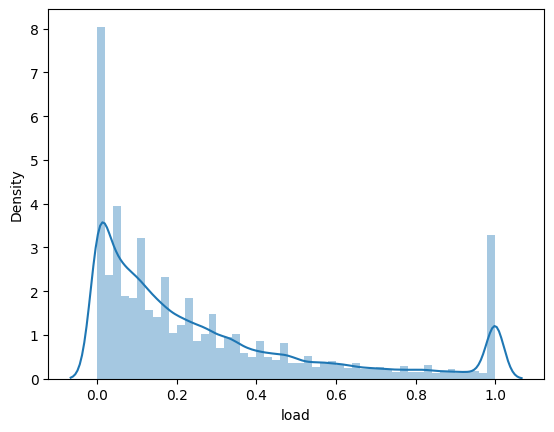

In [ ]:
# plot the distribution of the load
sns.distplot(data['load'])
plt.show()

In [ ]:
data.describe()

id           name  calculatedCourse      longitude  \
count  399628.000000  399628.000000     399628.000000  399628.000000   
mean     9565.211739    3307.832304        179.039311     -74.447655   
min      4839.000000     127.000000          0.000000     -74.466677   
25%      4874.000000    4002.000000        102.764289     -74.456276   
50%      7179.000000    4110.000000        159.370120     -74.447971   
75%     13217.000000    4190.000000        278.493370     -74.438401   
max     18021.000000    4910.000000        359.996661     -74.428583   
std      5009.166109    1556.983842         98.432650       0.009867   

            latitude        paxLoad       totalCap          more  \
count  399628.000000  399628.000000  399628.000000  399628.00000   
mean       40.508068      17.752139      65.615047     101.25503   
min        40.478865       0.000000      30.000000      11.00000   
25%        40.499141       3.000000      67.000000     101.00000   
50%        40.506826      11.000000      67.000000     102.00000   
75%        40.523542      25.000000      67.000000     102.00000   
max        40.526545      80.000000      80.000000     105.00000   
std         0.015216      19.329839       7.976636       5.42775   

            deviceId   routeBlockId                      timestamp  \
count  399628.000000  399628.000000                         399628   
mean   414279.467220  107670.394114  2024-11-04 17:08:04.921404416   
min    402213.000000    5450.000000            2024-10-31 18:24:00   
25%    402709.000000  111420.000000            2024-11-02 00:47:06   
50%    411189.000000  111610.000000            2024-11-05 02:23:08   
75%    422712.000000  112513.000000            2024-11-06 16:29:28   
max    441428.000000  117898.000000            2024-11-07 21:51:49   
std     12065.619209   17892.536776                            NaN   

                load  
count  399628.000000  
mean        0.271459  
min         0.000000  
25%         0.053333  
50%         0.164179  
75%         0.388060  
max         1.000000  
std         0.290512

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Get unique timestamps
timestamps = data['timestamp'].dt.floor('s').unique()

# Data for the number of buses running (as before)
route_name = 'LX Route'
data_route = data[data['routeName'] == route_name]

# Calculate bus count at each timestamp
bus_count = []
for timestamp in timestamps:
    bus_count.append(data_route[data_route['timestamp'].dt.floor('s') == timestamp]['deviceId'].nunique())

# Normalize bus count for color mapping
norm = mcolors.Normalize(vmin=min(bus_count), vmax=max(bus_count))
cmap = plt.cm.viridis  # Use a colormap like 'viridis' or 'plasma'
colors = cmap(norm(bus_count))

# Data for average load (as before)
load = []
for timestamp in timestamps:
    load.append(data_route[data_route['timestamp'].dt.floor('s') == timestamp]['load'].mean())

# Create a scatter plot with colors based on bus count
plt.scatter(timestamps, load, c=colors, cmap=cmap, edgecolor='k', s=50)  # Use a scatter plot for visual clarity
plt.xticks(rotation=45)
plt.title(f'Average Load on {route_name} Route (Color Coded by Bus Count)')
plt.xlabel('Time')
plt.ylabel('Average Load')
plt.ylim(0)

# Add a colorbar to explain the hue
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Number of Buses Operating')

plt.show()


In [10]:
# print the unique values of deviceId
print(data['deviceId'].unique())

[402213 402325 402329 402330 402643 402645 402694 402696 402698 402699
 402702 402708 402709 402720 402723 402727 402729 402741 402867 405190
 405378 405382 405404 406275 411181 411187 411189 411194 415102 415104
 415105 417554 417555 417562 422692 422694 422698 422700 422708 422712
 428735 429476 429478 429482 429484 441420 441424 441426 405380 417553
 402733 402215 422714 417557 402707 402695 441418 402739 402646 402647
 441428 441422]


In [11]:
# print the unique values of routeBlockId
print(data['routeBlockId'].unique())

[111417 113278 113250 112511 111413 111418 111416 113248 111580 112513
 111532 111677 111679 111639 111601 111531 117896 113249 111422 117897
 111602 111680 111642 111579 117895 111421 111533 111678 111641 111640
 112512 111420 111411 111535 113246 111423 112747 111329 111582 111676
   5451 111534 112510 111419 113245 111581 111603 117898 113251 113252
 111644 111643 112514 112515 111681 112516 111682 111425 111683 111424
 111340 111426 111646 111605 111604 111645 111427 111341 111428 111606
 111648 111647 111429 111684 111538 111609 117892 112518 111685 111539
 117891 111430 113254 111649 111540 113253 111686 117893 113255 117894
 111610 111608 112519 111431   5452 111432 111607 111650 111433 111687
 113256 111541 111611 111542 111435 111688 111613 111612   5453 111614
 111434 111652 111543 112725 111544 113258 111615 111545 111616 111653
 111536 111689 113257 111436 113259 112520 112521 111651 111342 112723
 111617 111655 112724 111618 111654  70470  70455  70471  70456  70457
  7047

In [12]:
# for each unique routeBlockId, print the average value of latitude and longitude as well as load
for routeBlockId in data['routeBlockId'].unique():
    print(routeBlockId)
    print(data[data['routeBlockId'] == routeBlockId].mean())
    print()

111417


TypeError: can only concatenate str (not "int") to str

In [13]:
# get the average latitude and longitude for each routeBlockId
# plot the location of each routeBlockId
locations = data.groupby('routeBlockId').mean()
locations = locations[['latitude', 'longitude']]
locations.reset_index(inplace=True)

m = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=15)
mc = MarkerCluster()
for idx, row in locations.iterrows():
    mc.add_child(folium.Marker(location=[row['latitude'], row['longitude']], tooltip=row['routeBlockId']))
m.add_child(mc)
m.save('maps/map.html')

TypeError: agg function failed [how->mean,dtype->object]

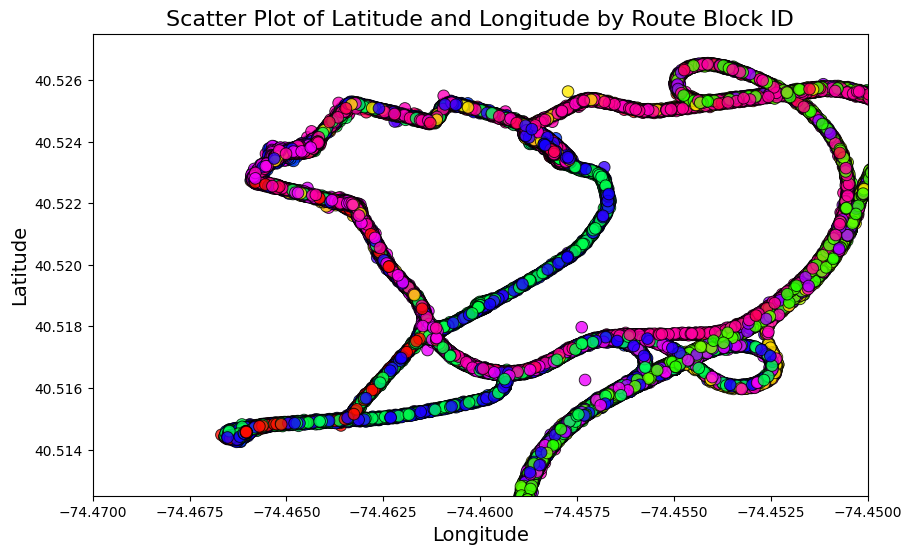

In [14]:
# Determine a color palette that adapts to the unique number of routeBlockId values
unique_route_blocks = data['routeBlockId'].nunique()
palette = sns.color_palette("hsv", unique_route_blocks)

# Create scatter plot with routeBlockId as hue and customized color palette
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=data, 
    x='longitude', 
    y='latitude', 
    hue='routeBlockId', 
    palette=palette, 
    s=70, 
    edgecolor='k', 
    alpha=0.8,
    legend=False
)

# Add titles and labels for better readability
plt.title("Scatter Plot of Latitude and Longitude by Route Block ID", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

# Set plot limits
plt.ylim(40.5125, 40.5275)
plt.xlim(-74.47, -74.45)

# Display legend outside the plot
# plt.legend(title="Route Block ID", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as ctx

# Determine a color palette that adapts to the unique number of routeBlockId values
unique_route_blocks = data['routeBlockId'].nunique()
palette = sns.color_palette("hsv", unique_route_blocks)

# Create scatter plot with routeBlockId as hue and customized color palette
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=data, 
    x='longitude', 
    y='latitude', 
    hue='routeBlockId', 
    palette=palette, 
    s=70, 
    edgecolor='k', 
    alpha=0.8,
    legend=False
)

# Add titles and labels for better readability
plt.title("Scatter Plot of Latitude and Longitude by Route Block ID", fontsize=16)
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

# Set plot limits
plt.ylim(40.5125, 40.5275)
plt.xlim(-74.47, -74.45)

# Add the map background with contextily
# Note: contextily expects coordinates in Web Mercator format
scatter_plot = scatter.get_figure()
scatter_plot.axes[0].set_xlim(-8282490, -8279740)
scatter_plot.axes[0].set_ylim(4964920, 4966700)

# Add a basemap; use crs="EPSG:3857" for Web Mercator
ctx.add_basemap(scatter_plot.axes[0], crs="EPSG:3857", source=ctx.providers.Stamen.TonerLite)

# Show the plot
plt.show()


ModuleNotFoundError: No module named 'contextily'

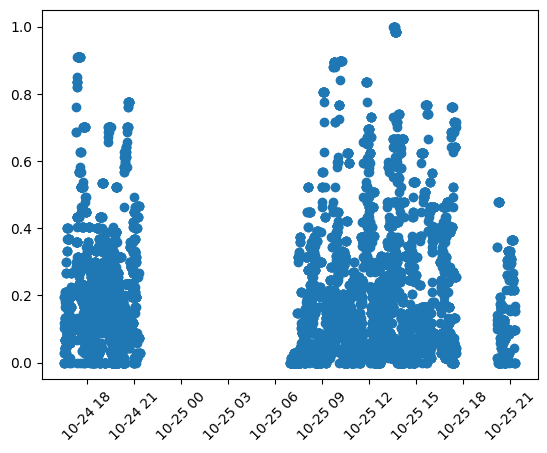

In [ ]:
# get a specific route and plot the scatter plot of load over time
route = 'A Route'
data_route = data[data['routeName'] == route]
plt.scatter(data_route['timestamp'], data_route['load'])
# make the x axis more readable
plt.xticks(rotation=45)
plt.show()

C:\Users\akash\AppData\Local\Temp\ipykernel_22904\2412874025.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='routeName', y='load', data=data, palette='viridis')


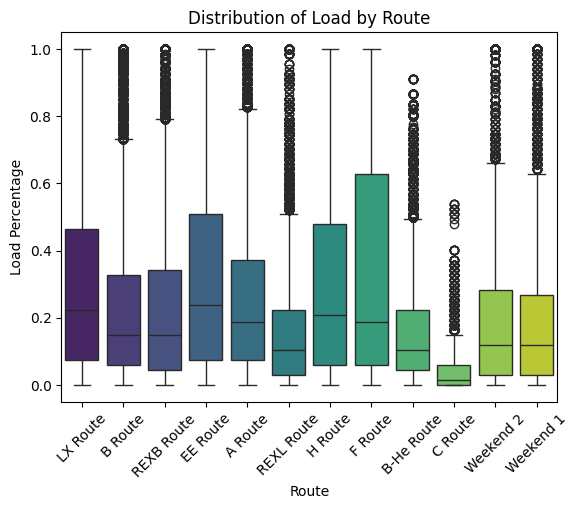

In [5]:
# plot the distribution of load for each route
sns.boxplot(x='routeName', y='load', data=data, palette='viridis')
plt.xticks(rotation=45)
plt.title('Distribution of Load by Route')
plt.xlabel('Route')
plt.ylabel('Load Percentage')
plt.show()

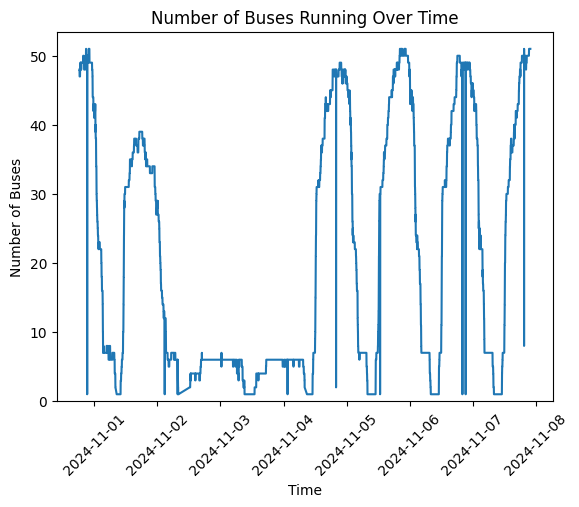

In [14]:
# make a line plot for the number of buses running at once
# get the unique timestamps
timestamps = data['timestamp'].dt.floor('s').unique()

# get the number of buses running at each timestamp
bus_count = []
for timestamp in timestamps:
    bus_count.append(data[data['timestamp'].dt.floor('s') == timestamp]['deviceId'].nunique())

plt.plot(timestamps, bus_count)
plt.xticks(rotation=45)
plt.title('Number of Buses Running Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Buses')
plt.ylim(0)
plt.show()

(0.0, 0.7929850746268657)

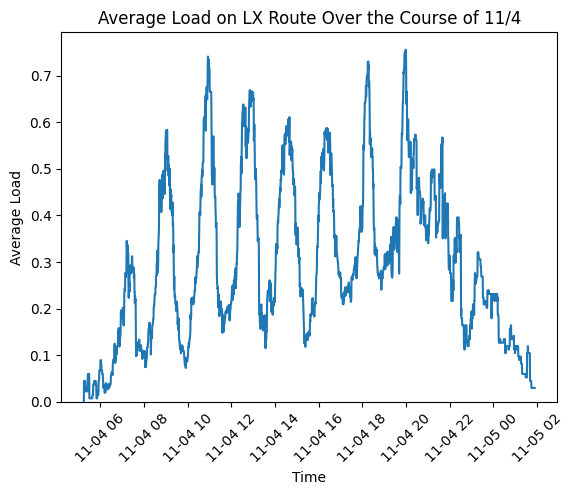

In [22]:
# show average load on LX route over time
route = 'LX Route'

# limit the data to one day
data_time = data[(data['timestamp'] >= '2024-11-04') & (data['timestamp'] < '2024-11-05 3:00')]

# use timestamps from previous cell
data_route = data_time[data_time['routeName'] == route]

# get the average load at each timestamp
timestamps = data_route['timestamp'].dt.floor('s').unique()
load = []
for timestamp in timestamps:
    load.append(data_route[data_route['timestamp'].dt.floor('s') == timestamp]['load'].mean())

plt.plot(timestamps, load)
plt.xticks(rotation=45)
plt.title('Average Load on LX Route Over the Course of 11/4')
plt.xlabel('Time')
plt.ylabel('Average Load')
plt.ylim(0)

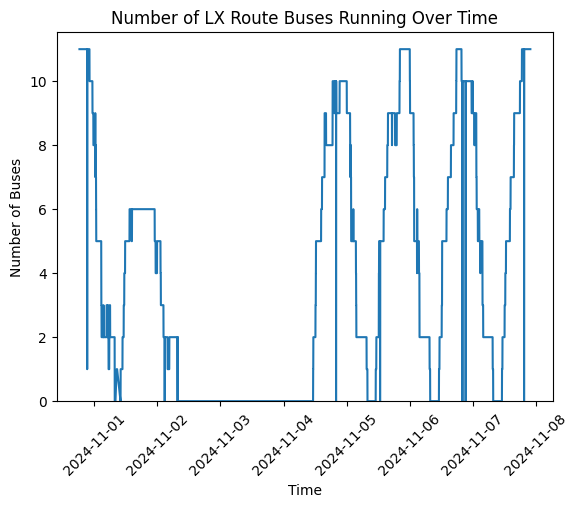

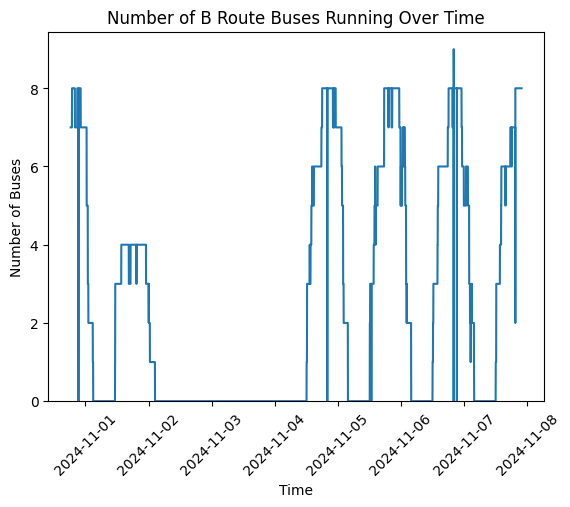

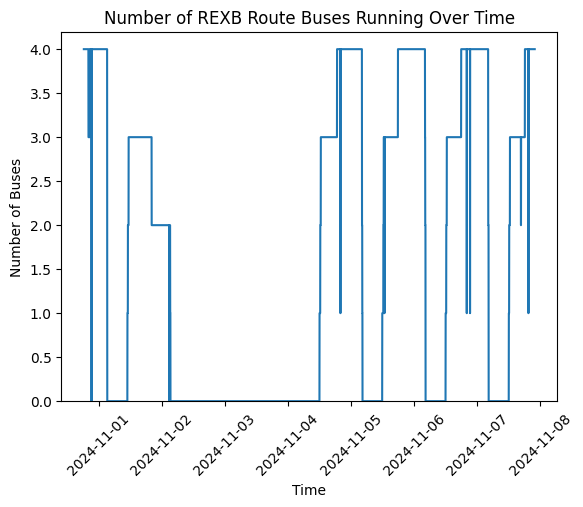

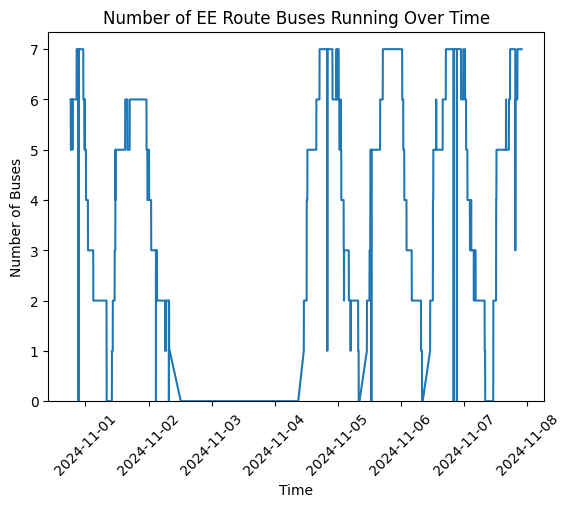

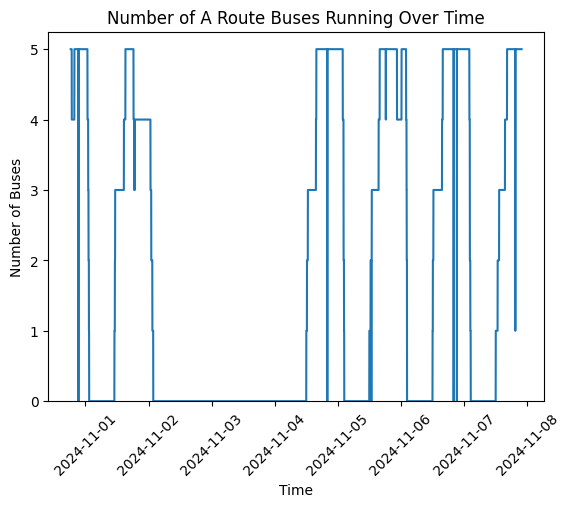

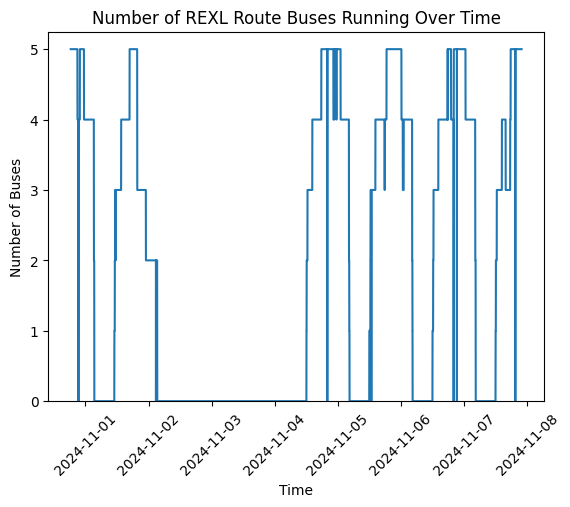

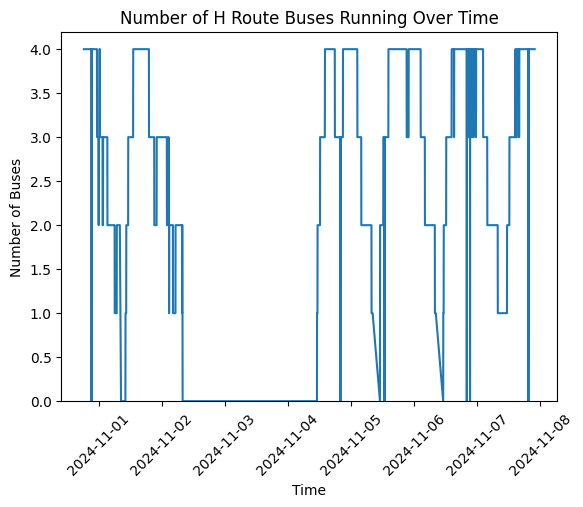

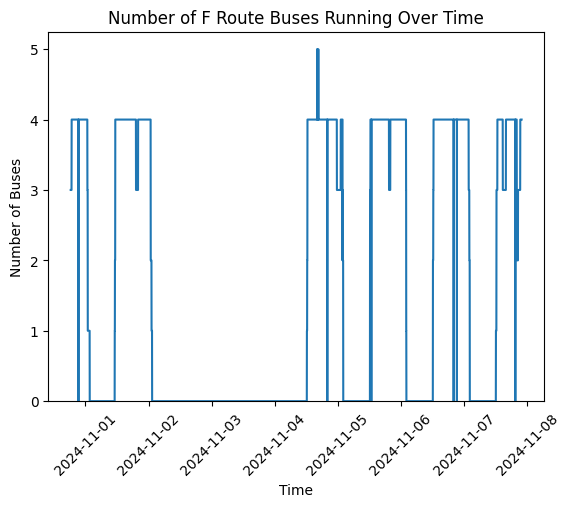

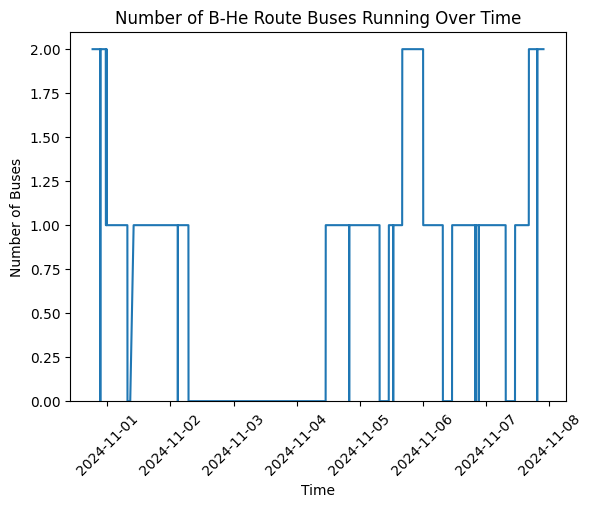

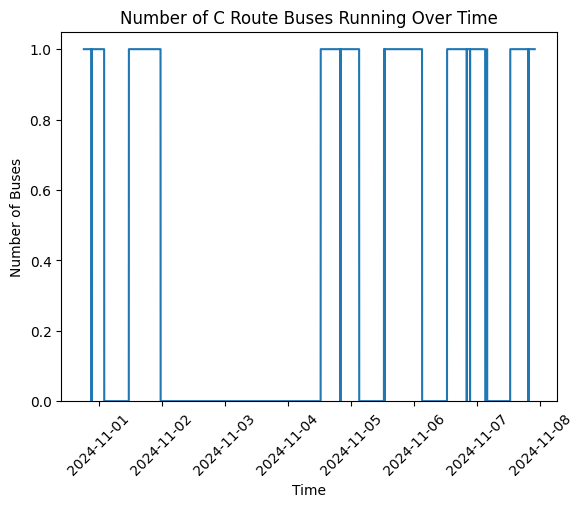

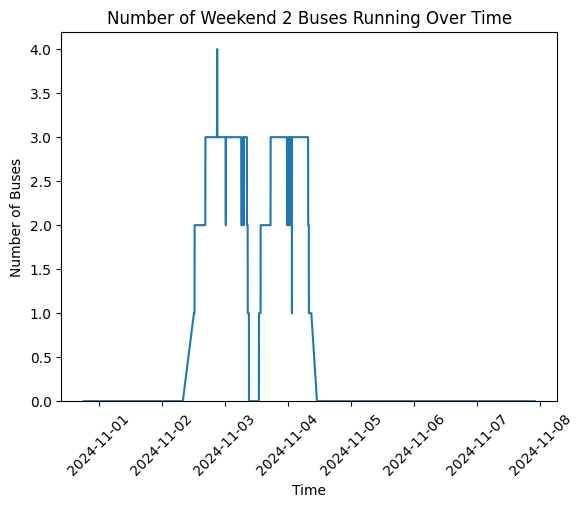

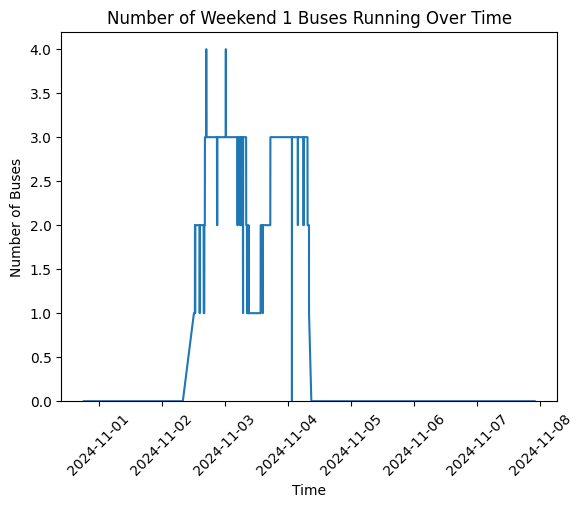

In [13]:
# make a line plot for the number of buses running for a specific route over time
# get the unique timestamps
timestamps = data['timestamp'].dt.floor('s').unique()

for route in data['routeName'].unique():
    data_route = data[data['routeName'] == route]
    
    # get the number of buses running at each timestamp
    bus_count = []
    for timestamp in timestamps:
        bus_count.append(data_route[data_route['timestamp'].dt.floor('s') == timestamp]['deviceId'].nunique())

    plt.plot(timestamps, bus_count)
    plt.xticks(rotation=45)
    plt.title(f'Number of {route} Buses Running Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Buses')
    plt.ylim(0)
    plt.show()

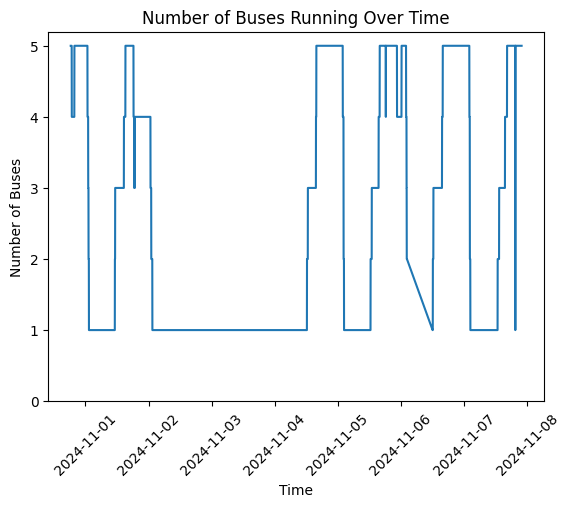

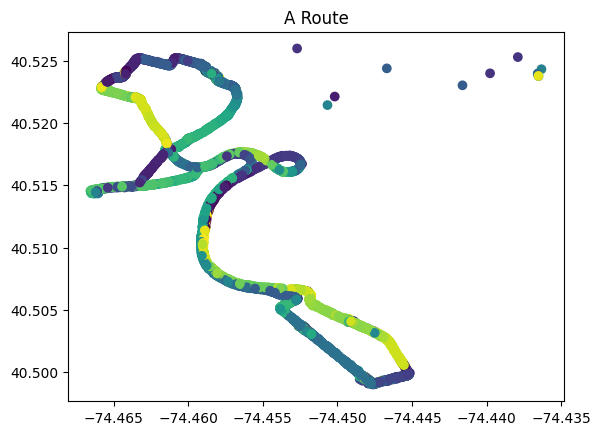

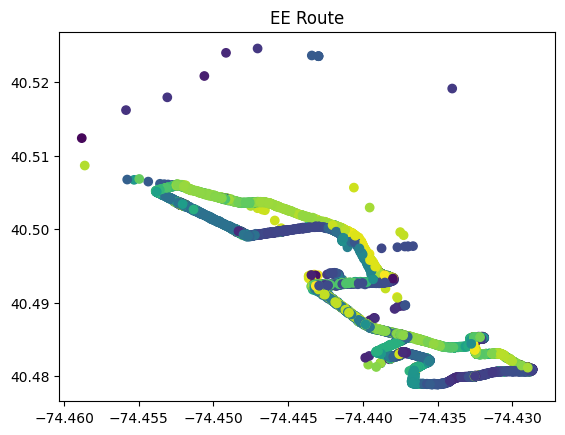

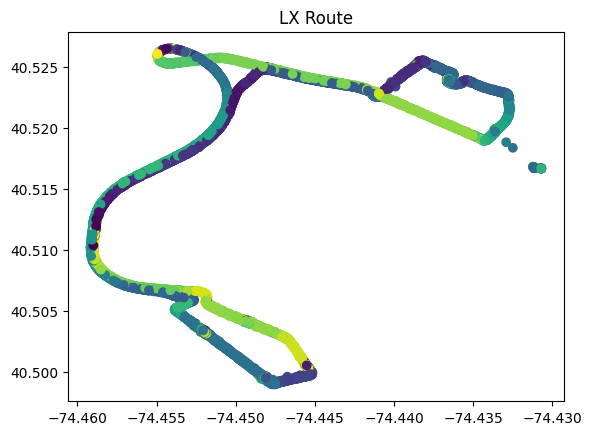

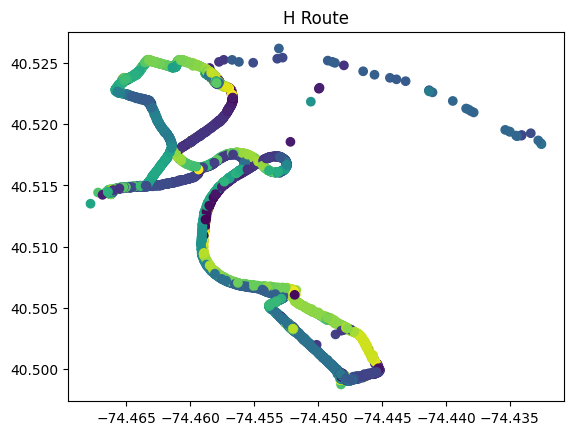

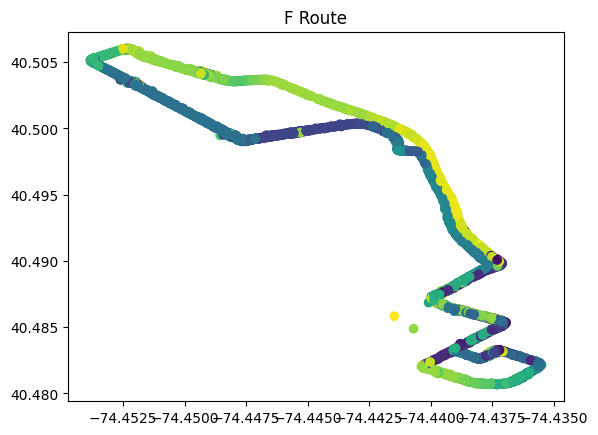

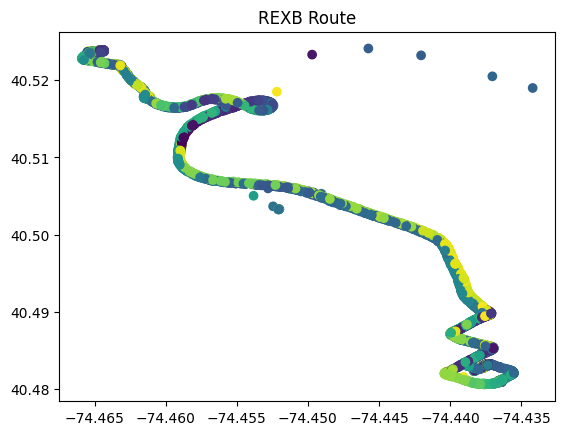

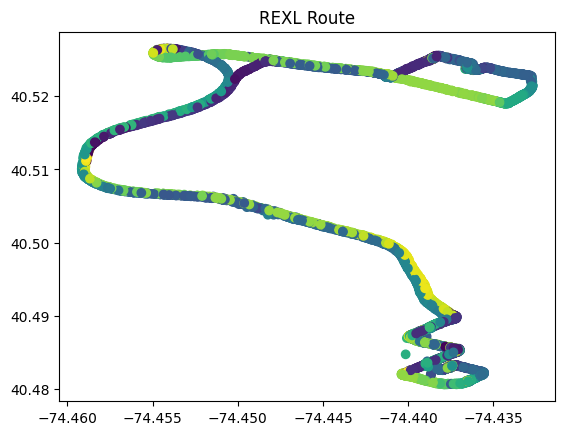

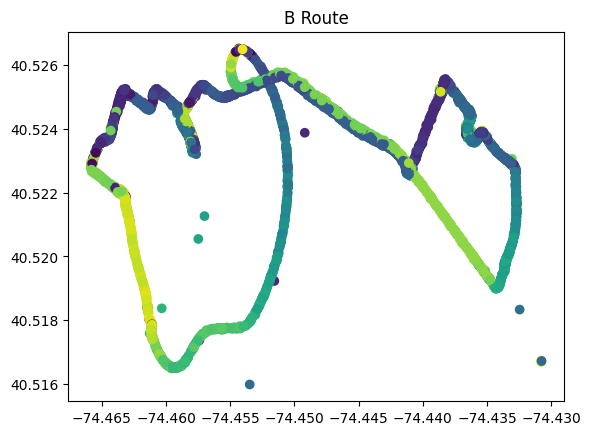

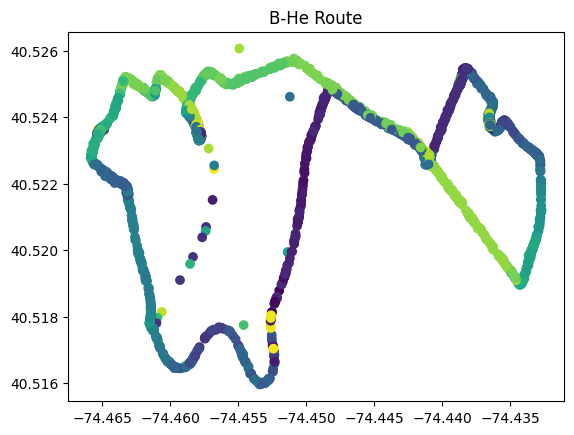

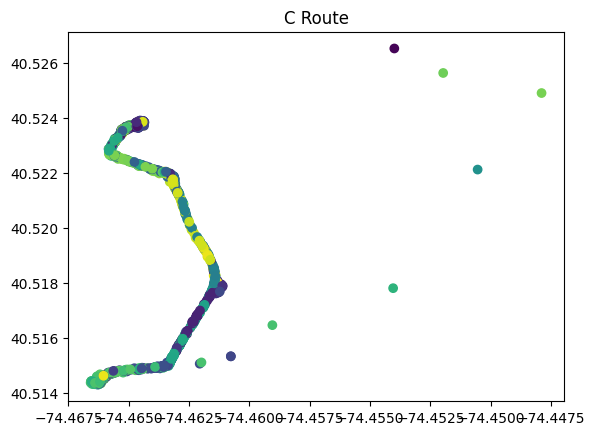

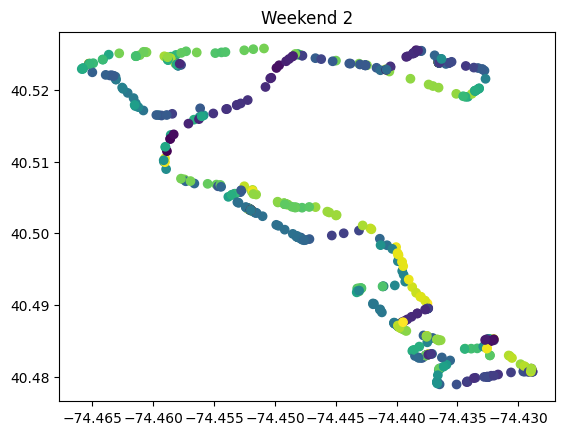

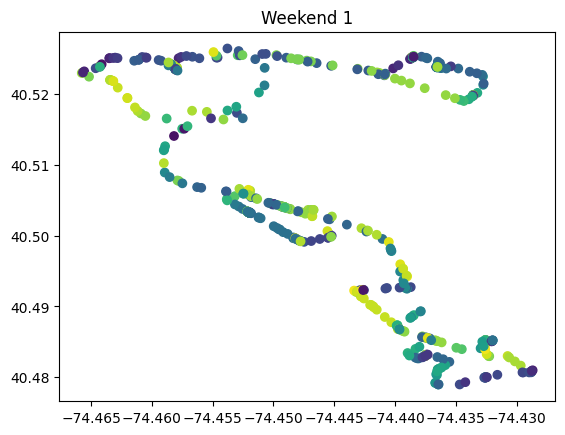

In [ ]:
# make a heat map with the longitude and latitude data for each route
for route in data['routeName'].unique():
    data_route = data[data['routeName'] == route]
    plt.scatter(data_route['longitude'], data_route['latitude'], c=data_route['calculatedCourse'])
    plt.title(route)
    plt.show()

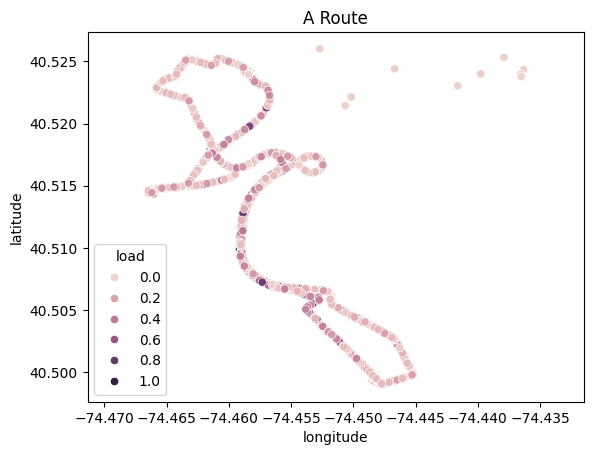

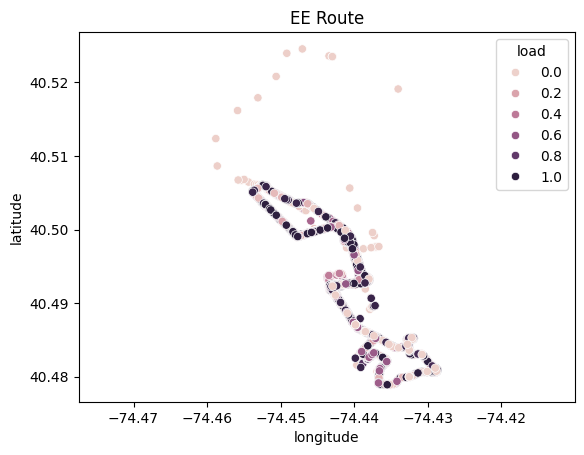

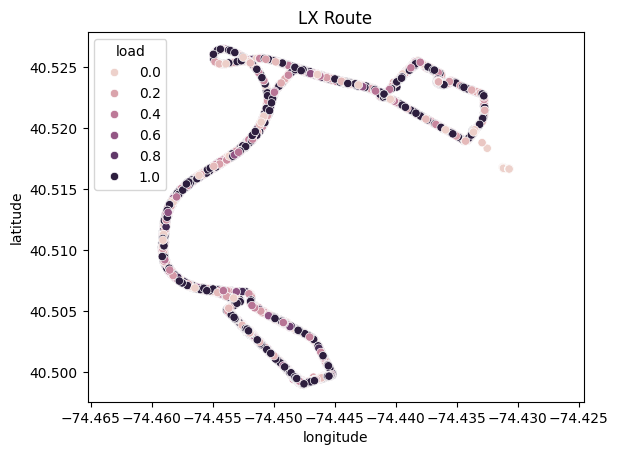

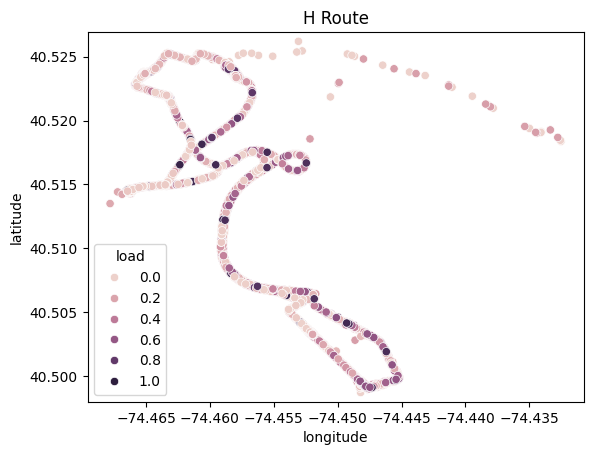

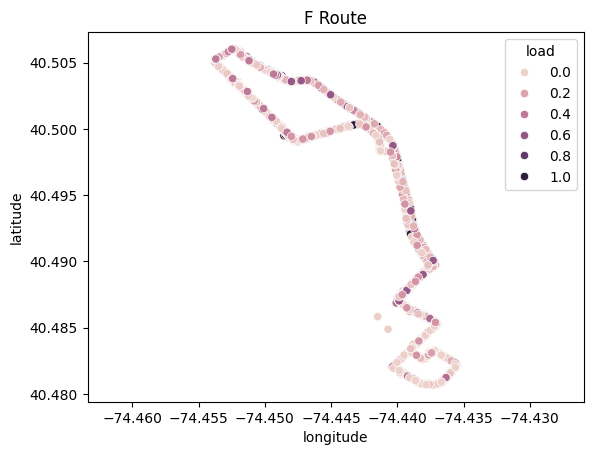

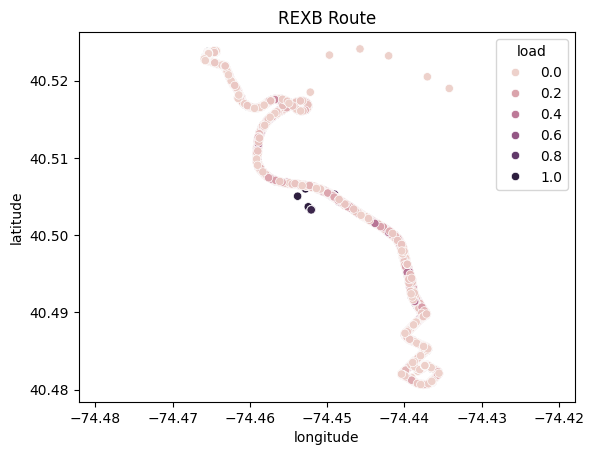

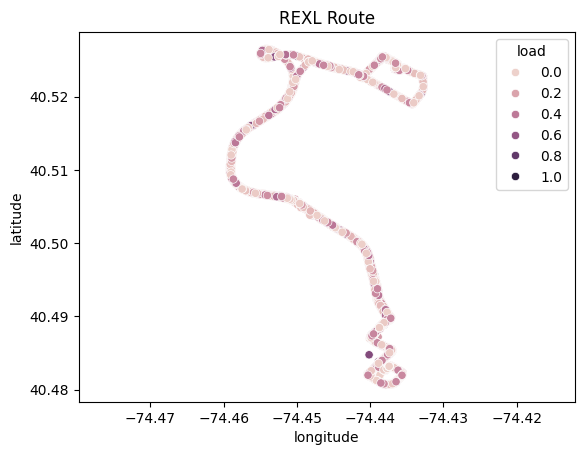

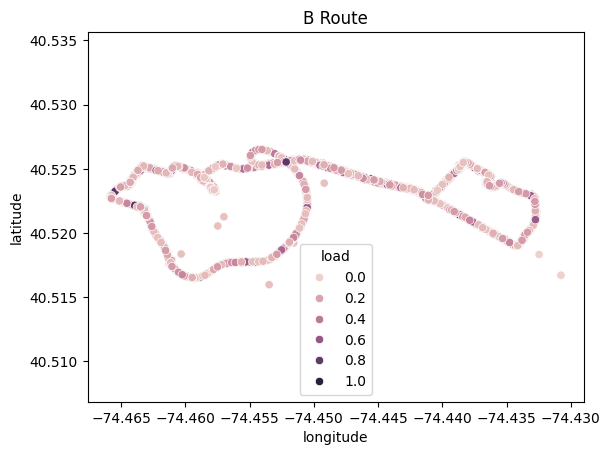

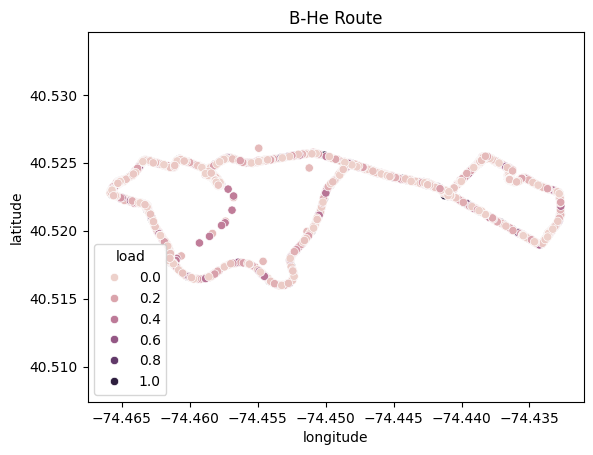

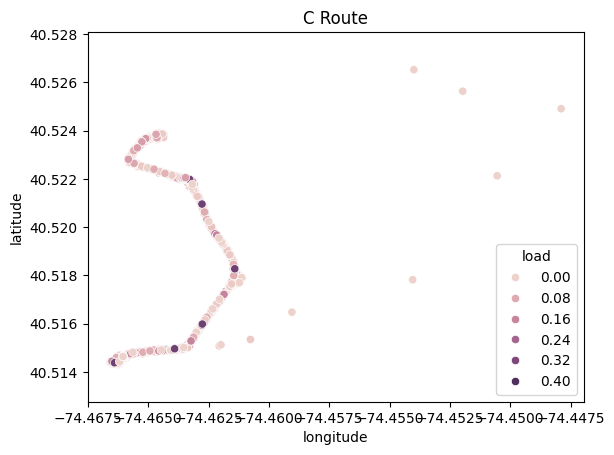

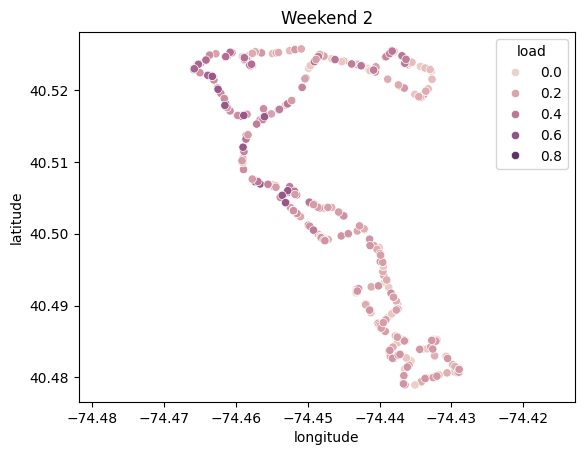

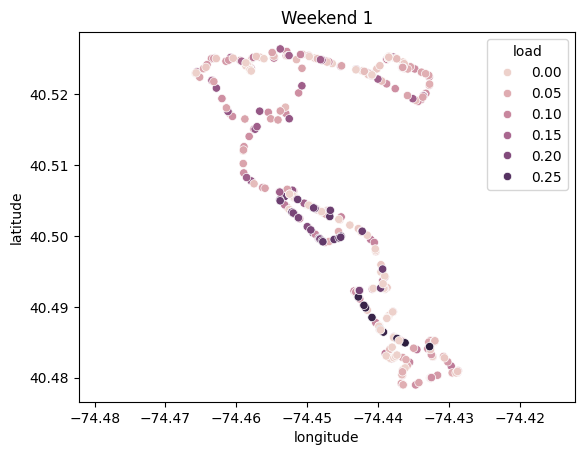

In [ ]:
# plot the scatter plot of longitude and latitude for each route as well as hue for the load
for route in data['routeName'].unique():
    data_route = data[data['routeName'] == route]
    sns.scatterplot(x='longitude', y='latitude', hue='load', data=data_route)
    plt.title(route)

    # make it so that the x and y scale is the same
    plt.axis('equal')
    plt.show()

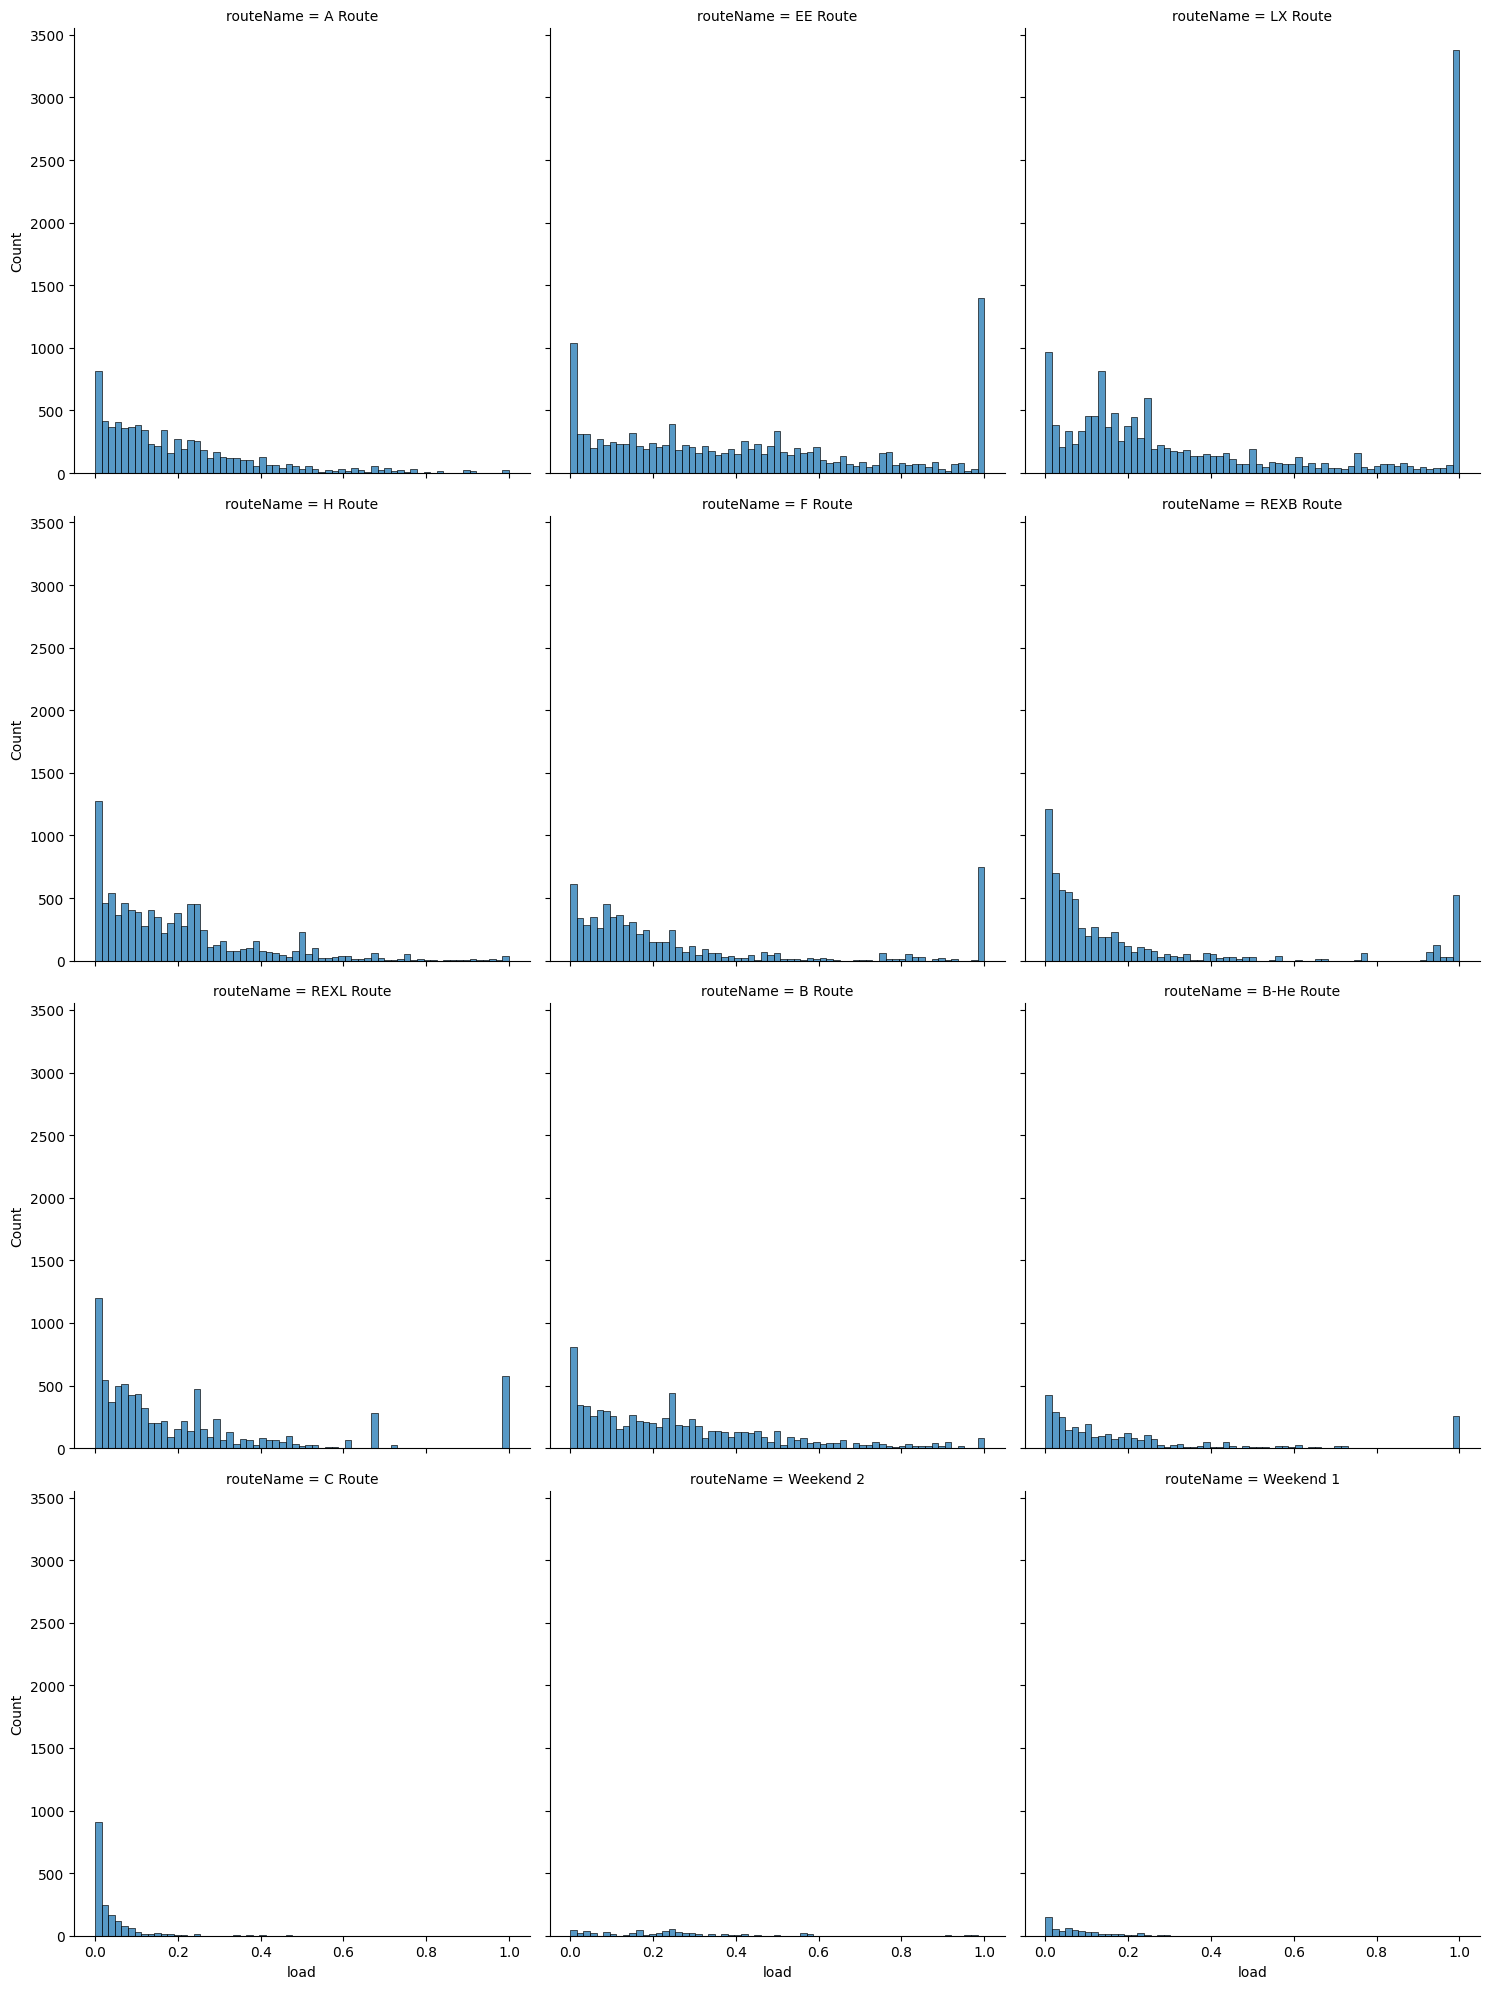

In [ ]:
# graph the distribution of more
sns.displot(data, x='load', col='routeName', col_wrap=3)
plt.show()

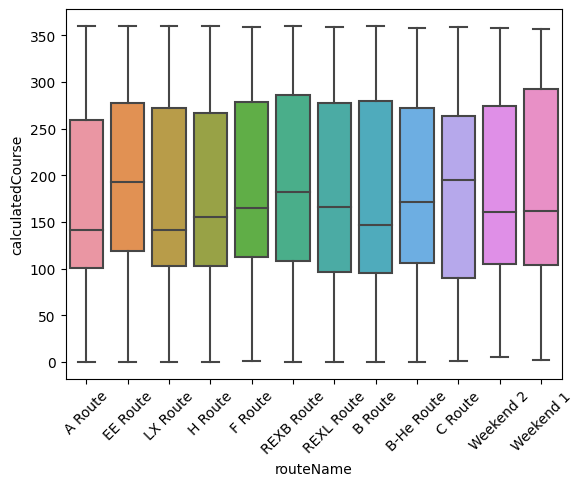

In [ ]:
# plot the distribution of calc course for each route
sns.boxplot(x='routeName', y='calculatedCourse', data=data)
plt.xticks(rotation=45)
plt.show()

In [ ]:
for route in data['routeName'].unique():
    data_route = data[data['routeName'] == route]

    # Initialize map at an approximate central location of your data
    map_route = folium.Map(
        location=[data_route['latitude'].mean(), data_route['longitude'].mean()],
        zoom_start=12
    )

    # Add points with MarkerCluster for better visualization
    marker_cluster = MarkerCluster().add_to(map_route)
    for _, row in data_route.iterrows():
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color="blue" if row['load'] < 0.3 else "red",  # Adjust color based on load threshold
            fill=True,
            fill_opacity=0.7
        ).add_to(marker_cluster)

    # Show or save the map
    map_route.save(f"maps/{route}_map.html")  # Save as HTML file
    map_route


C:\Users\akash\AppData\Local\Temp\ipykernel_22952\2889258366.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='timestamp', y='load', data=data_route, palette='tab10')


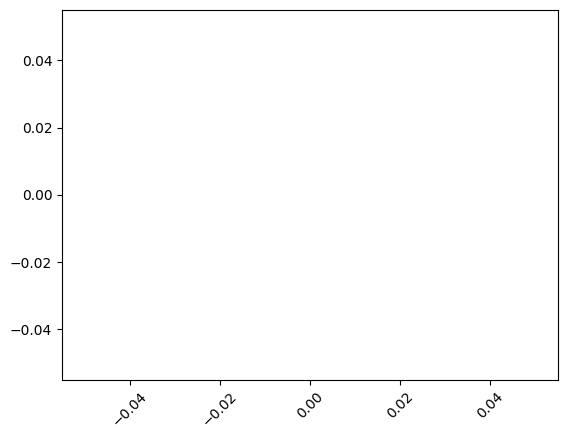

In [ ]:
# get a specific route and plot the scatter plot of load over time
route = 'Weekend 1'
data_route = data[data['routeName'] == route]

# get the time values between two times
start_time = pd.Timestamp('2024-10-31 12:00:00')
end_time = pd.Timestamp('2024-11-04 19:30:00')

data_route = data_route[(data_route['timestamp'] > start_time) & (data_route['timestamp'] < end_time)]

# at each distinct timestamp, get the average load
data_route = data_route.groupby('timestamp').mean().reset_index()

# add a hue for each device id
sns.scatterplot(x='timestamp', y='load', data=data_route, palette='tab10')

plt.xticks(rotation=45)
plt.show()

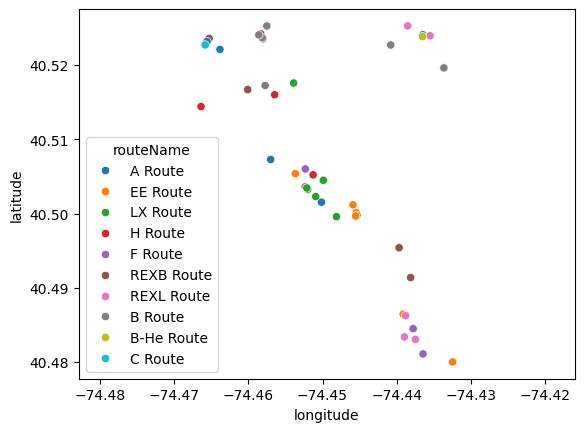

In [ ]:
times = data['timestamp'].unique()

time = times[0]

# plot the location of the buses at a specific time
data_time = data[data['timestamp'] == time]

# create a scatter plot with the hue as the route name
sns.scatterplot(x='longitude', y='latitude', hue='routeName', data=data_time)
# make the x and y scale the same
plt.axis('equal')
plt.show()

C:\Users\akash\AppData\Local\Temp\ipykernel_12548\4174053210.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('temp.png'))
C:\Users\akash\AppData\Local\Temp\ipykernel_12548\4174053210.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread('temp.png'))
C:\Users\akash\AppData\Local\Temp\ipykernel_12548\4174053210.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio`

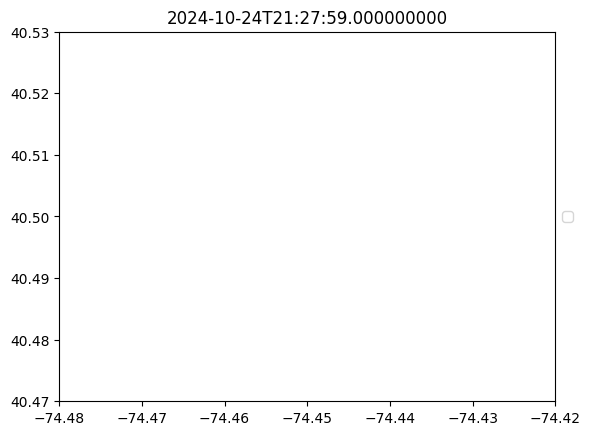

In [ ]:
# make a video of the buses over time
import imageio

images = []

bus_id = data['deviceId'].unique()[0]
bus_data = data[data['deviceId'] == bus_id]

try:
    for time in times:
        data_time = bus_data[bus_data['timestamp'] == time]

        plt.figure()
        sns.scatterplot(x='longitude', y='latitude', hue='routeName', data=data_time)
        plt.ylim(40.47, 40.53)
        plt.xlim(-74.48, -74.42)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.title(time)
        plt.savefig('temp.png')
        images.append(imageio.imread('temp.png'))
        plt.close()

except KeyboardInterrupt:
    pass

imageio.mimsave('buses.gif', images, duration=0.1)

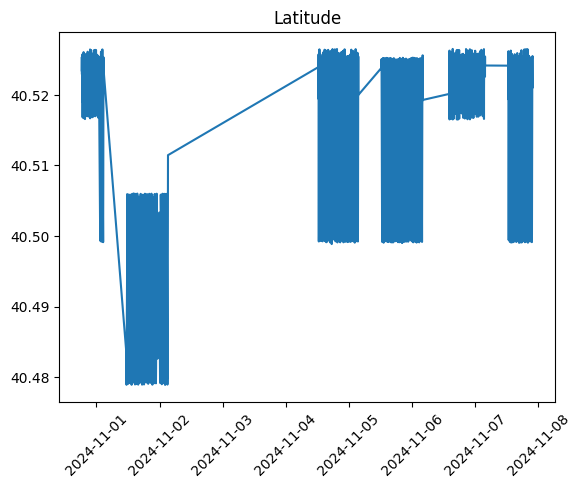

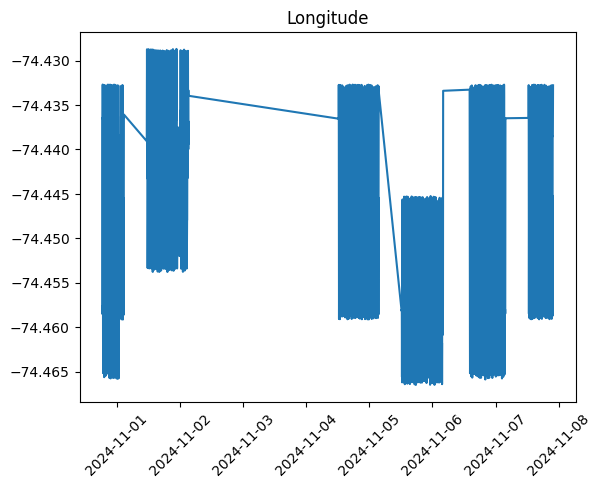

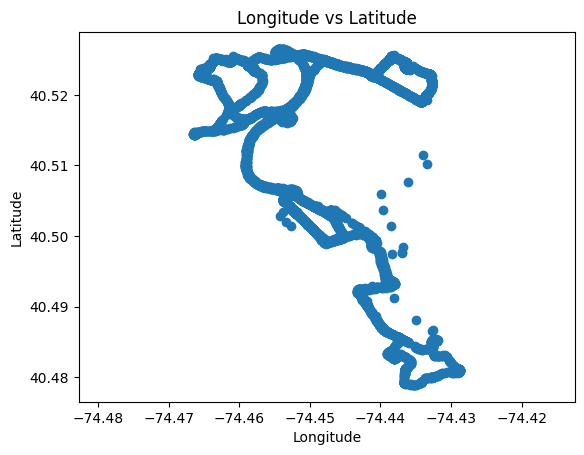

In [17]:
# pick a bus on its route and plot its latitute and longitude for a certain number of observations
bus_id = data['id'].unique()[2]

ROWS = 10000

data_bus = data[data['id'] == bus_id]
data_bus = data_bus.head(ROWS)

# make a line plot for the latitude and longitude
plt.plot(data_bus['timestamp'], data_bus['latitude'])
plt.title('Latitude')
plt.xticks(rotation=45)
plt.show()

plt.plot(data_bus['timestamp'], data_bus['longitude'])
plt.title('Longitude')
plt.xticks(rotation=45)
plt.show()

plt.scatter(data_bus['longitude'], data_bus['latitude'])
plt.title('Longitude vs Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [ ]:
# You can then use these points for plotting or other operations
# For example, plot the interpolated points on a map using folium:
m = folium.Map(location=[data_bus['latitude'].mean(), data_bus['longitude'].mean()], zoom_start=13)
# for row in data_bus make a point for it
for index, row in data_bus.iterrows():
    folium.Marker([row['latitude'], row['longitude']], radius=2, color='blue', fill=True, fill_color='blue').add_to(m)

m

In [ ]:
data.describe()

id          name  calculatedCourse     longitude  \
count  79712.000000  79712.000000      79712.000000  79712.000000   
mean    9417.224809   3211.250640        179.198192    -74.447872   
std     4621.225395   1606.324416         97.338536      0.010100   
min     4839.000000    127.000000          0.018745    -74.518140   
25%     4877.000000   3260.000000        103.873008    -74.457162   
50%     7181.000000   4038.000000        163.303638    -74.448140   
75%    13214.000000   4190.000000        273.814075    -74.438483   
max    17626.000000   4910.000000        359.970812    -74.186618   

           latitude       paxLoad      totalCap          more       deviceId  \
count  79712.000000  79712.000000  79712.000000  79712.000000   79712.000000   
mean      40.507767     19.590890     66.961875    101.495559  412956.294184   
std        0.015318     21.328391      7.079388      3.564675    9943.352184   
min       40.412717      0.000000     30.000000     11.000000  402213.000000   
25%       40.497621      4.000000     67.000000    101.000000  402720.000000   
50%       40.506680     12.000000     67.000000    102.000000  411189.000000   
75%       40.523497     27.000000     67.000000    102.000000  422698.000000   
max       40.739773     80.000000     80.000000    105.000000  429484.000000   

        routeBlockId          load  
count   79712.000000  79712.000000  
mean   109477.977381      0.289753  
std     16420.335250      0.303032  
min      5451.000000      0.000000  
25%    111533.000000      0.059701  
50%    111644.000000      0.179104  
75%    112517.000000      0.402985  
max    117898.000000      1.000000

In [ ]:
bus_id = 4855
data_bus = data[data['id'] == bus_id]
data_bus = data_bus.sort_values('timestamp')
data_bus.head()

id  name         type  calculatedCourse routeName   created  longitude  \
0    4855  4131  Transit Bus        135.131827   A Route  04:32 PM -74.450146   
48   4855  4131  Transit Bus        133.766005   A Route  04:32 PM -74.448791   
96   4855  4131  Transit Bus        136.339422   A Route  04:33 PM -74.448129   
144  4855  4131  Transit Bus         82.525166   A Route  04:33 PM -74.448071   
192  4855  4131  Transit Bus        133.584599   A Route  04:34 PM -74.447733   

      latitude  paxLoad  totalCap  more  deviceId  routeBlockId  \
0    40.501523        0        67   102    402213        111533   
48   40.500219        0        67   102    402213        111533   
96   40.499526        0        67   101    402213        111533   
144  40.499533        3        67   101    402213        111533   
192  40.499235        3        67   101    402213        111533   

              timestamp      load  
0   2024-10-24 16:32:24  0.000000  
48  2024-10-24 16:32:55  0.000000  
96  2024-10-24 16:33:25  0.000000  
144 2024-10-24 16:33:55  0.044776  
192 2024-10-24 16:34:25  0.044776

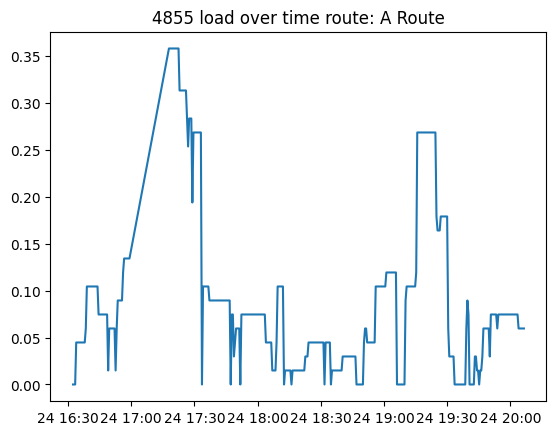

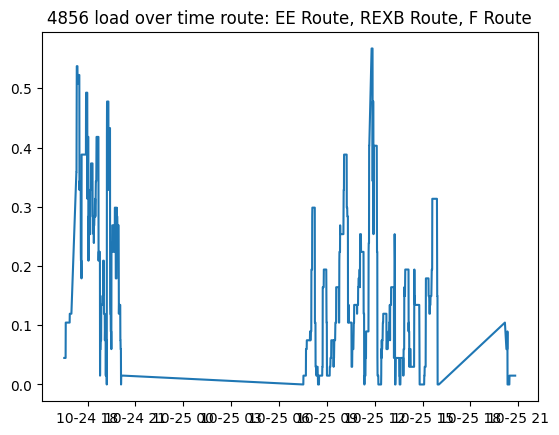

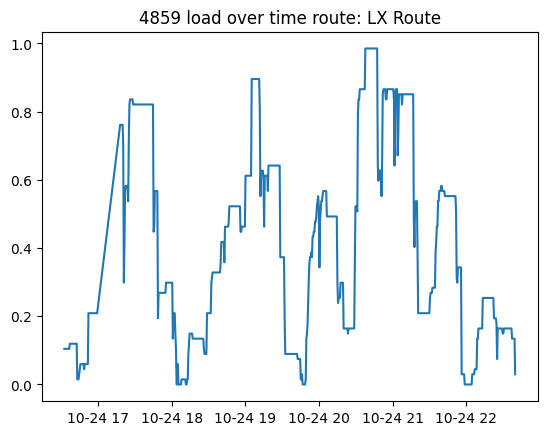

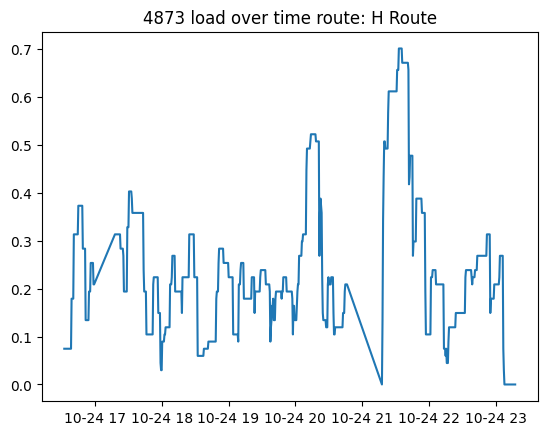

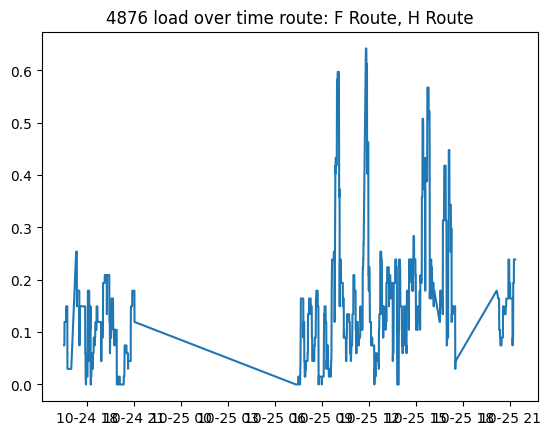

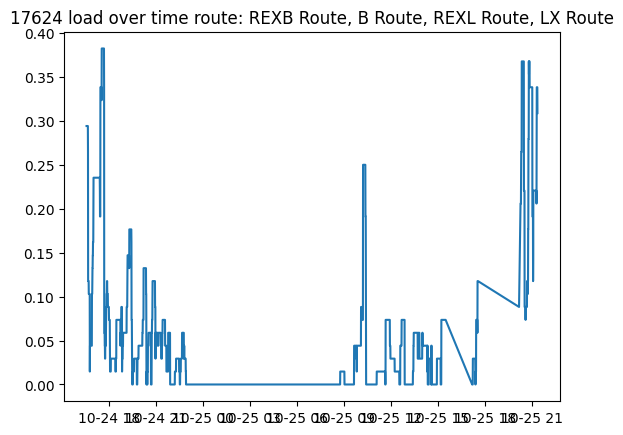

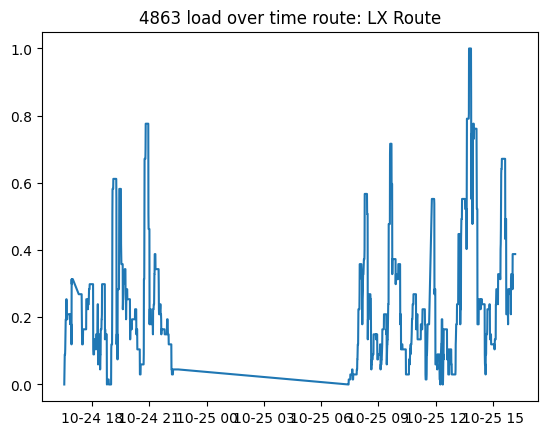

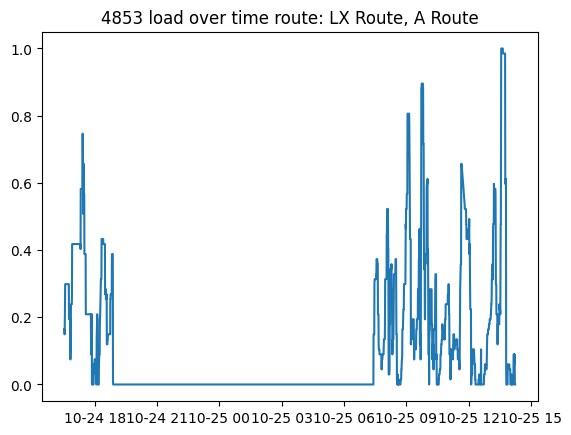

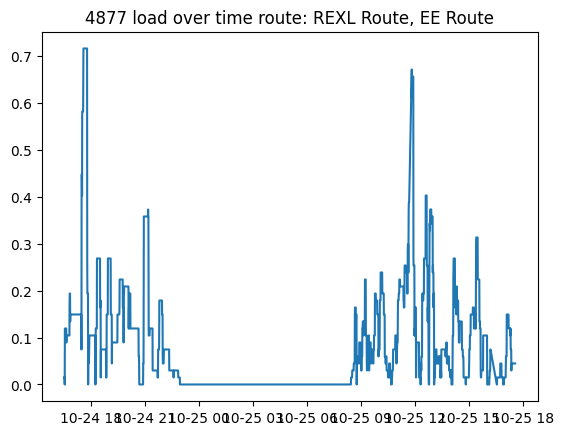

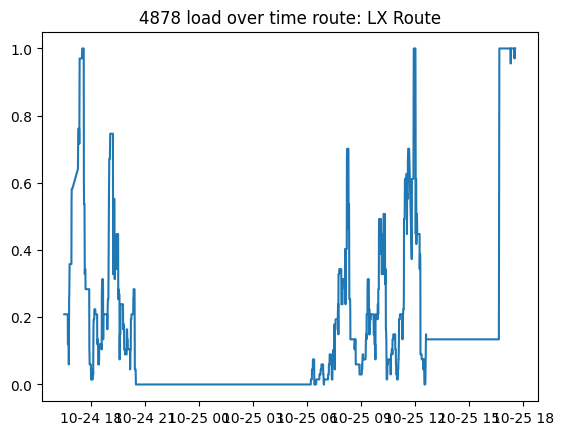

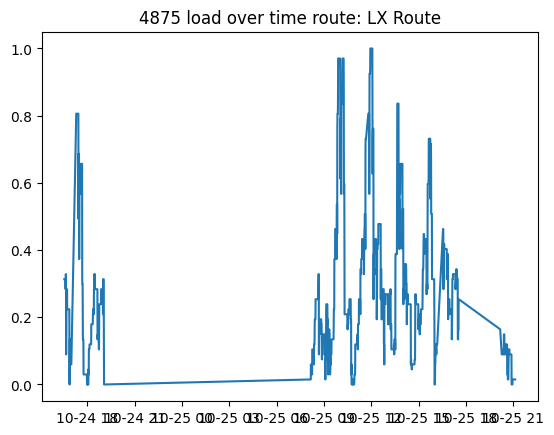

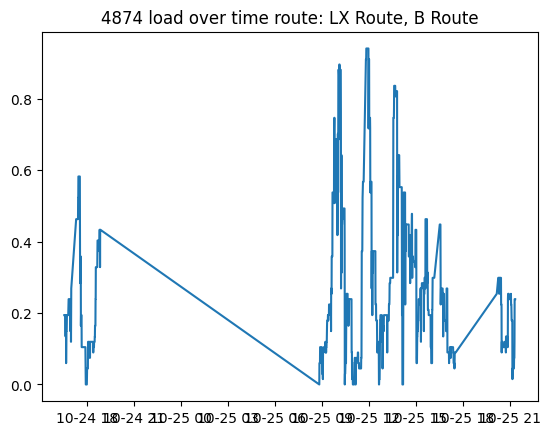

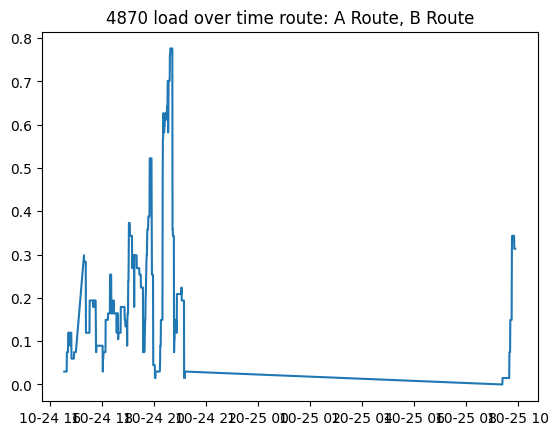

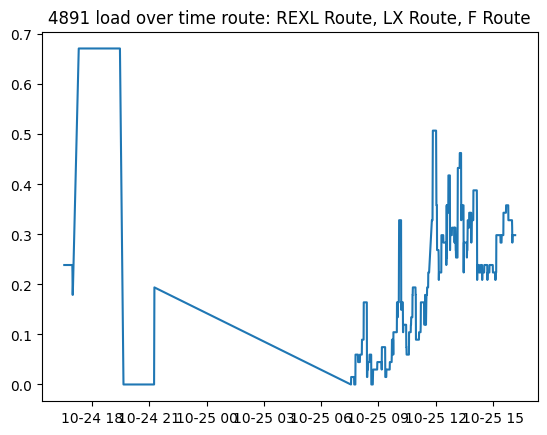

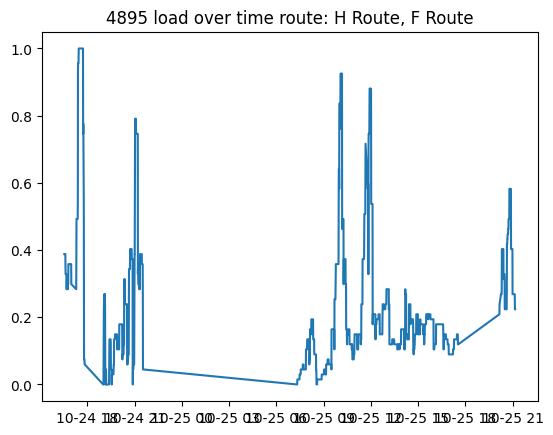

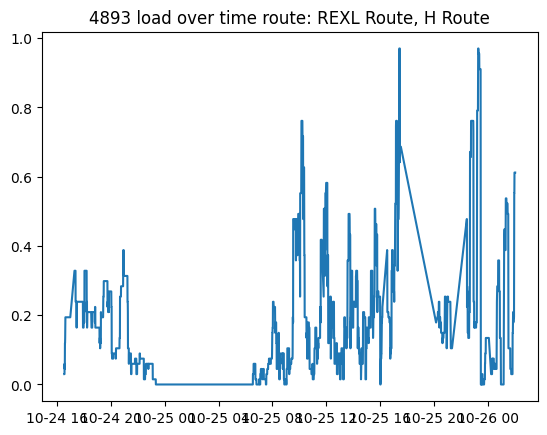

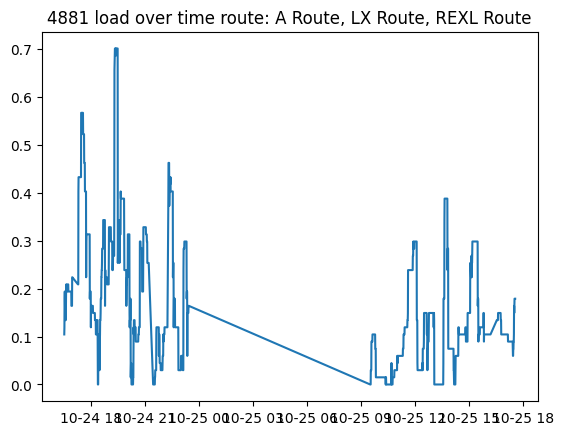

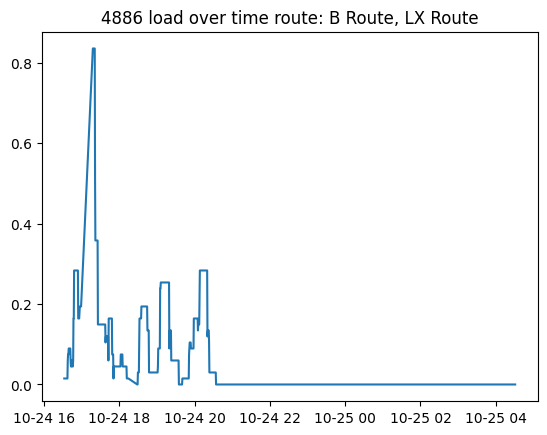

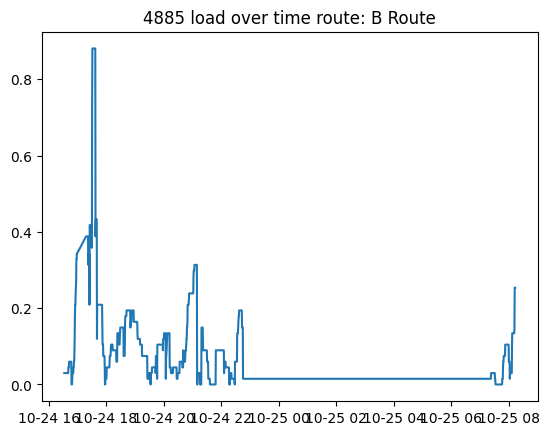

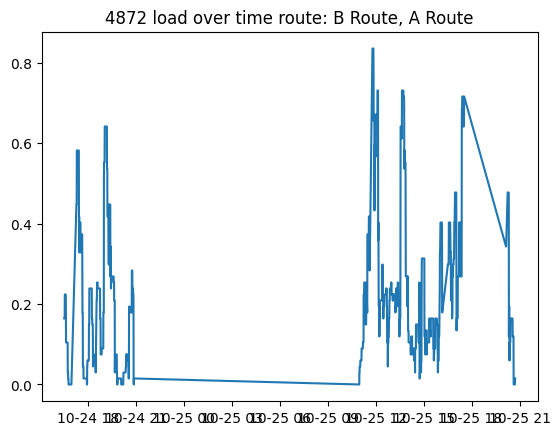

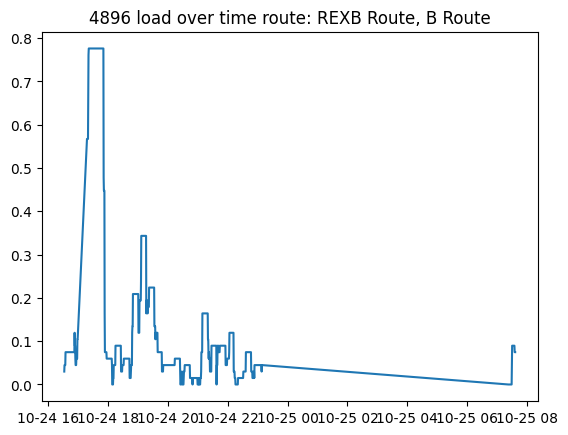

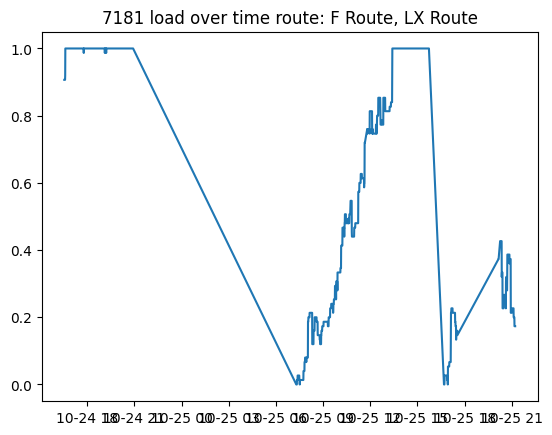

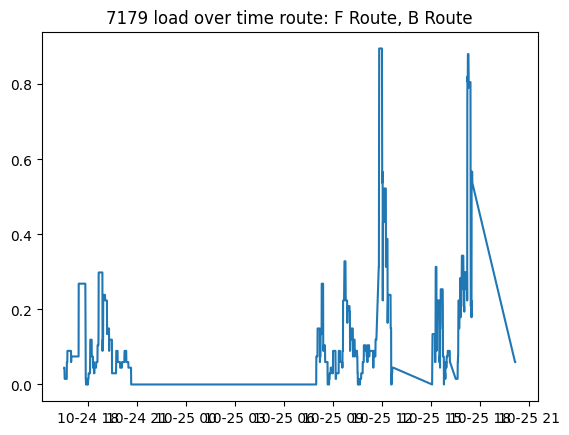

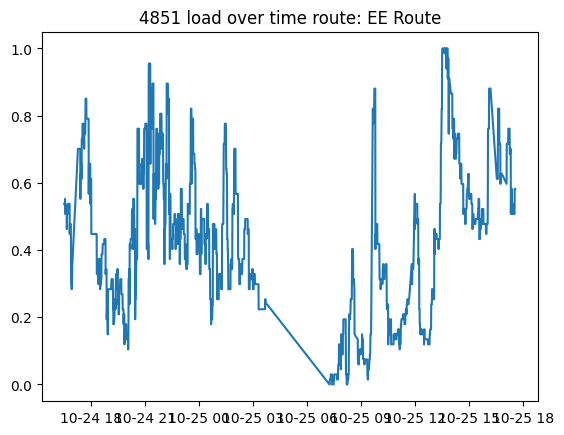

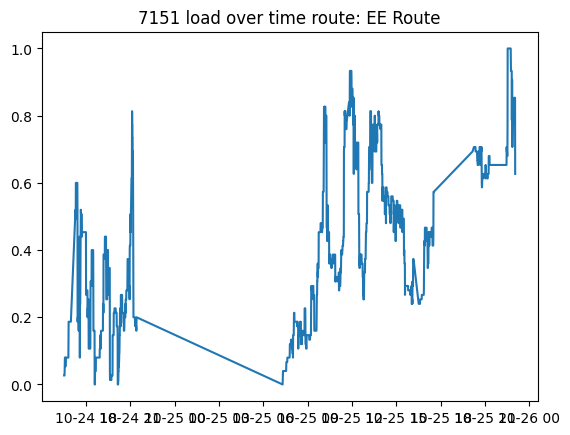

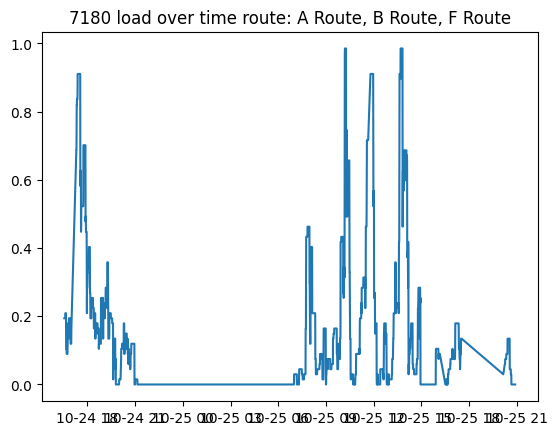

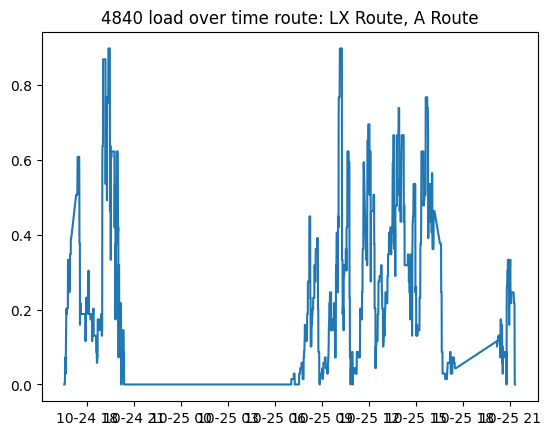

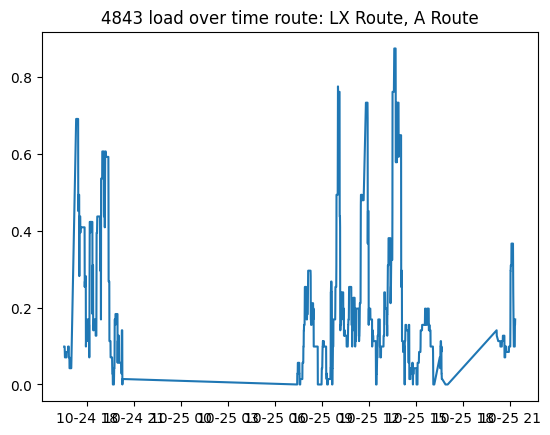

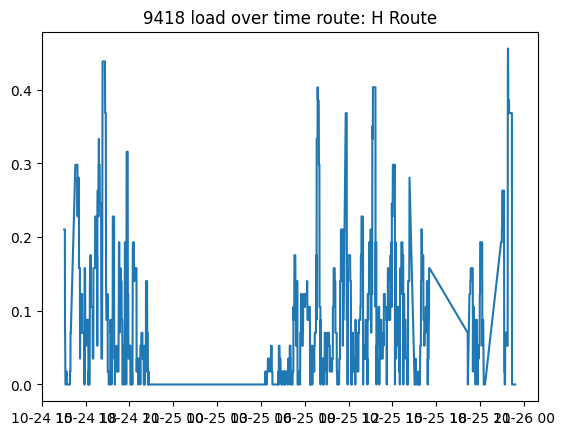

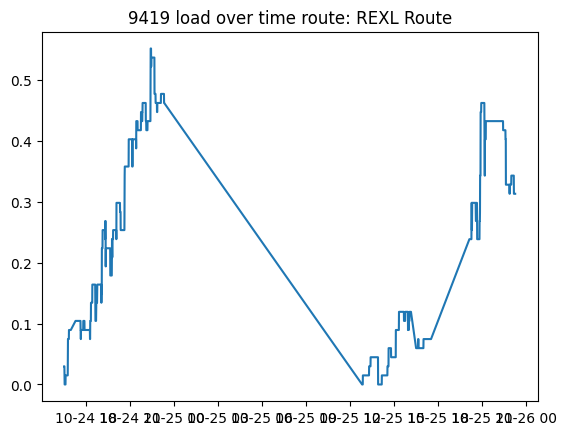

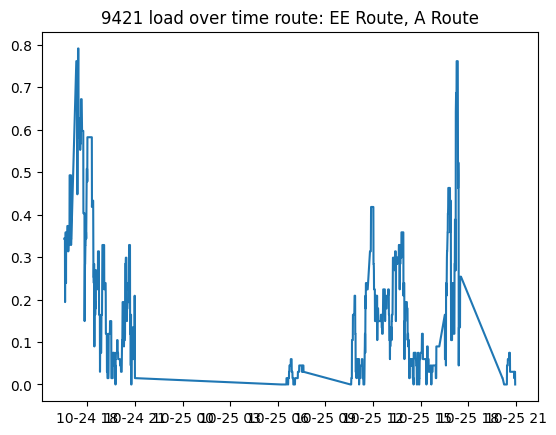

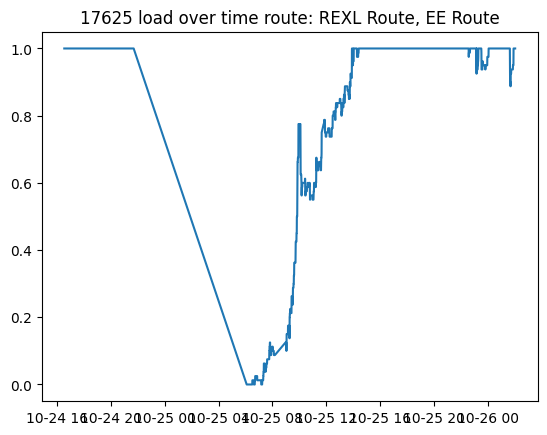

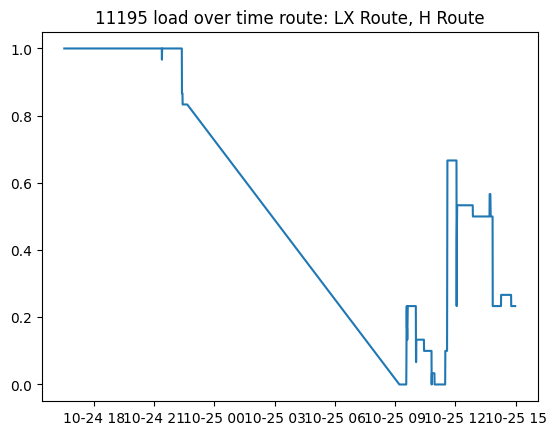

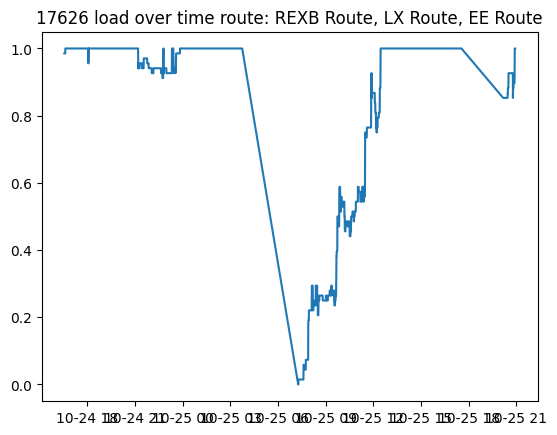

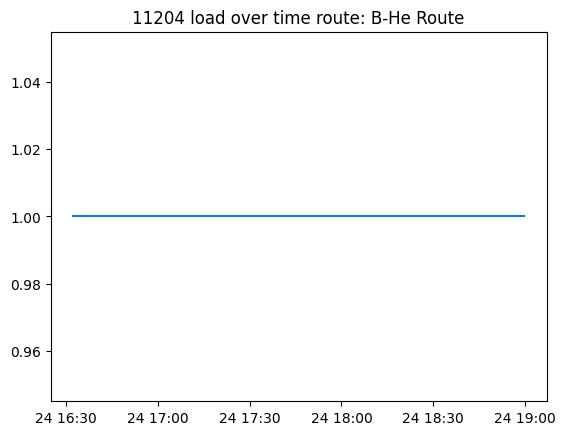

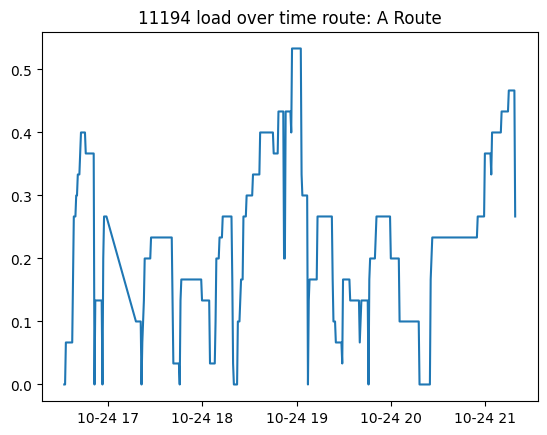

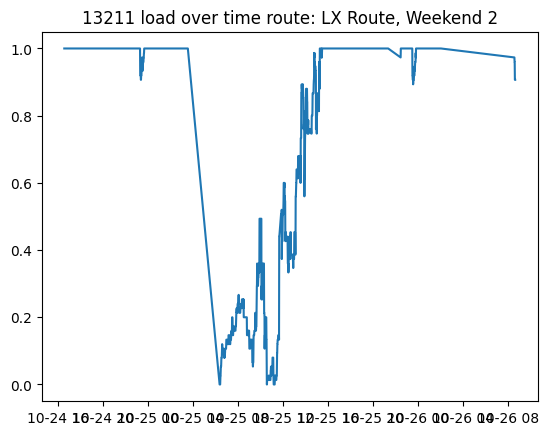

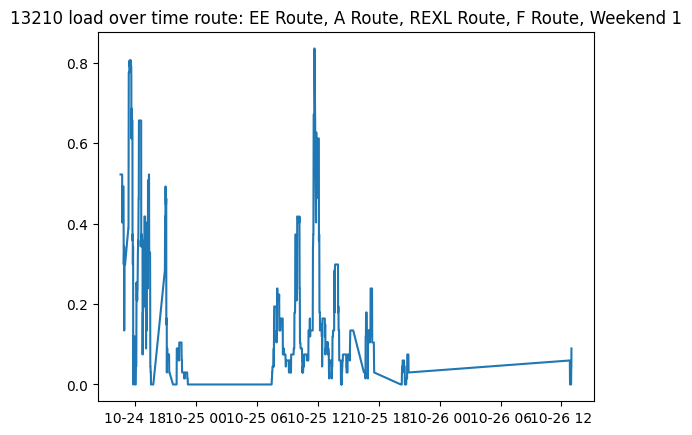

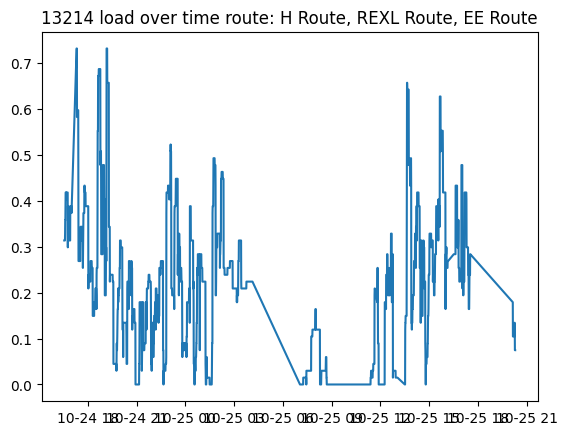

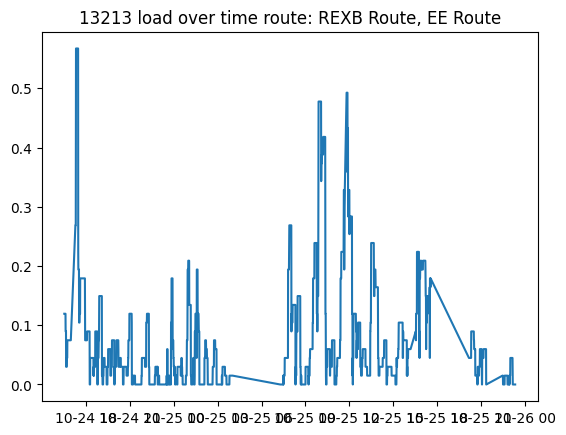

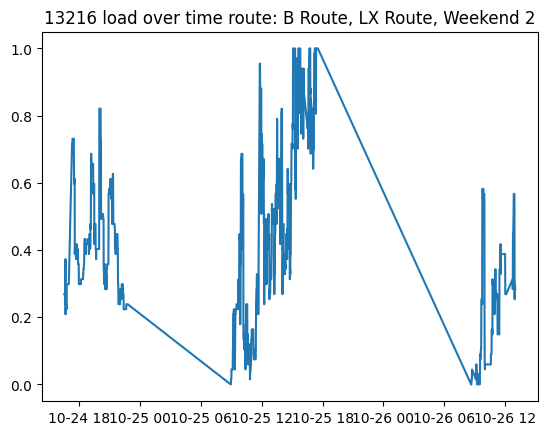

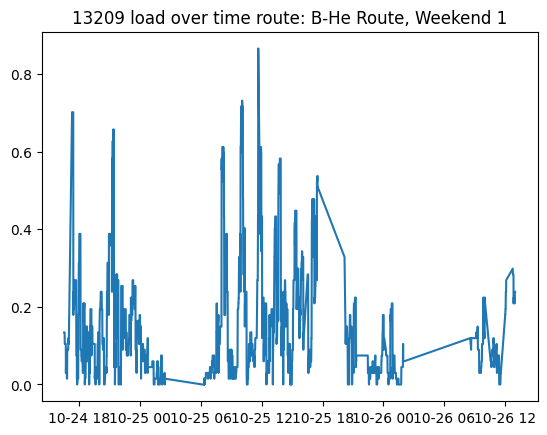

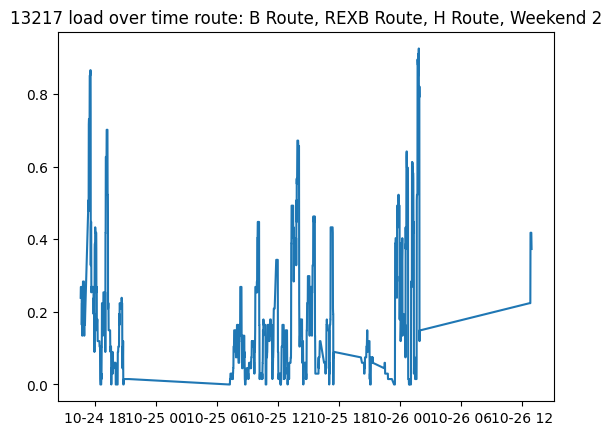

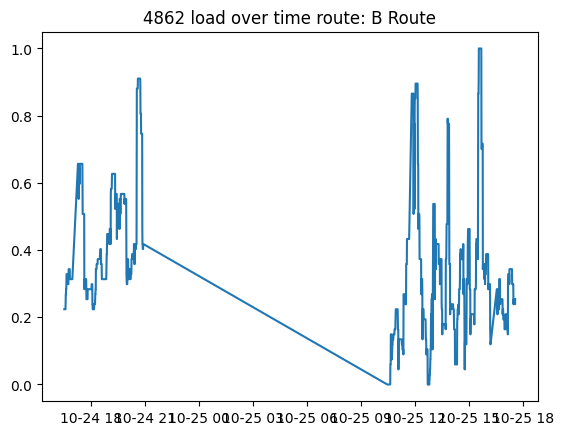

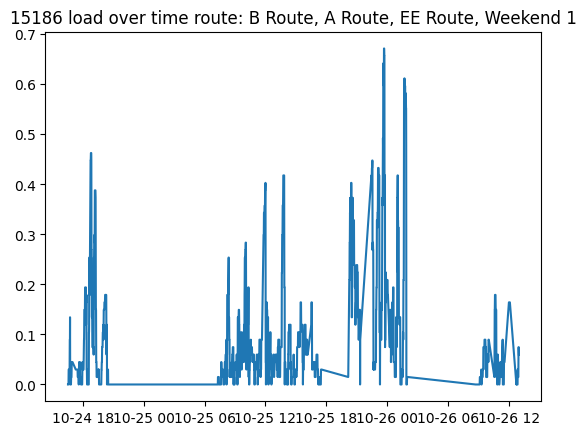

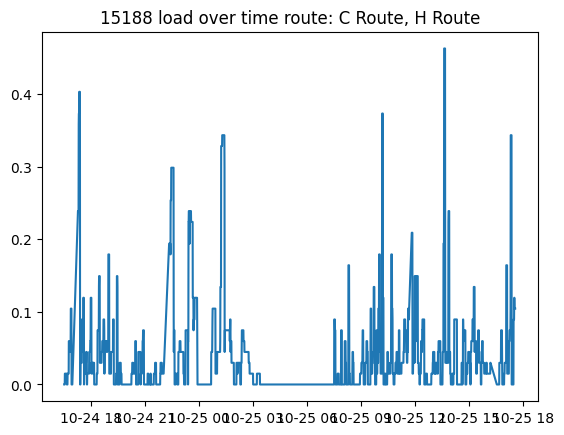

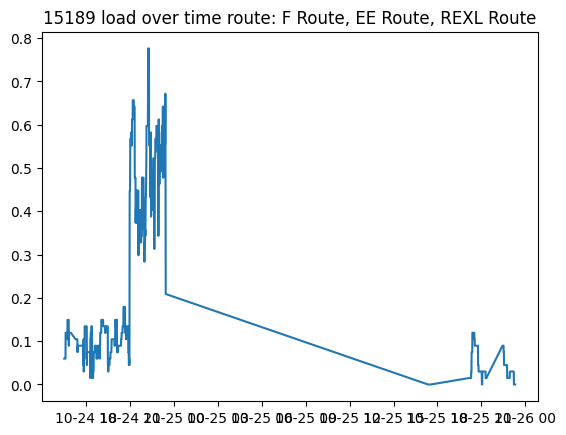

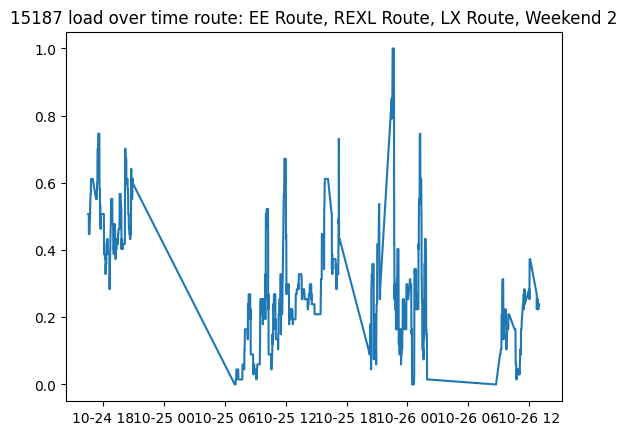

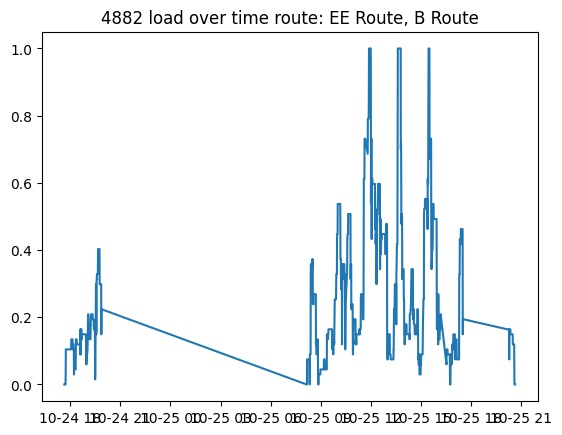

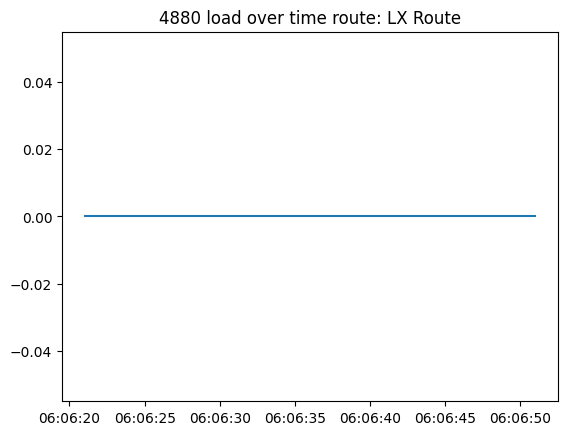

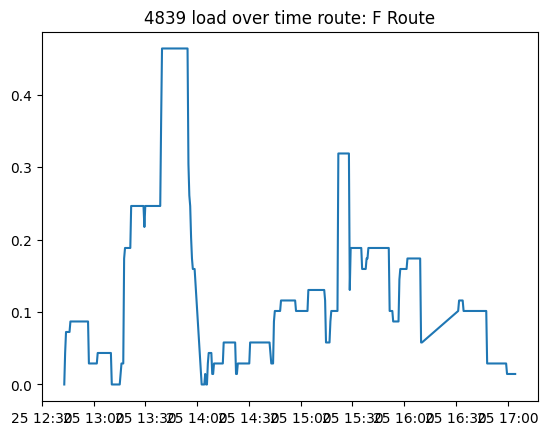

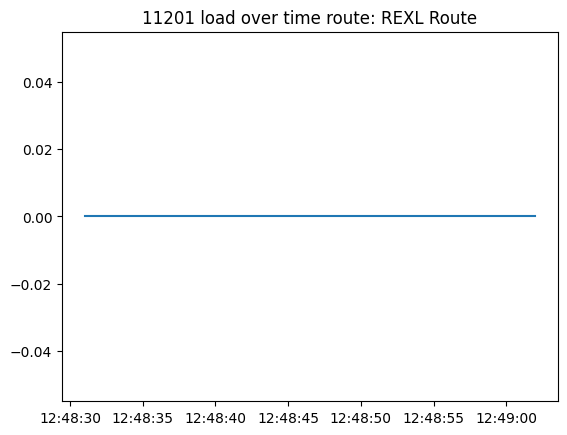

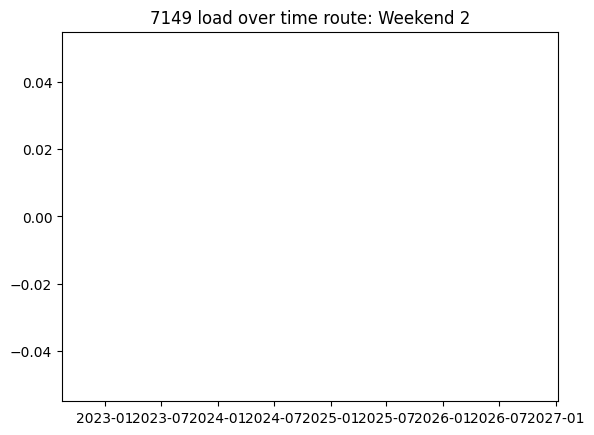

In [ ]:
for bus in data['id'].unique():
    data_bus = data[data['id'] == bus]
    plt.plot(data_bus['timestamp'], data_bus['load'], label=bus)
    plt.title(str(bus) + ' load over time' + ' route: ' + ', '.join(list(data_bus['routeName'].unique())))
    plt.show()

In [ ]:
bus_id = data['id'].unique()[2]

ROWS = 10000

data_bus = data[data['id'] == bus_id]
data_bus = data_bus.head(ROWS)

# You can then use these points for plotting or other operations
# For example, plot the interpolated points on a map using folium:
m = folium.Map(location=[data_bus['latitude'].mean(), data_bus['longitude'].mean()], zoom_start=13)
# for row in data_bus make a point for it
for index, row in data_bus.iterrows():
    folium.Marker([row['latitude'], row['longitude']], radius=2, color='blue', fill=True, fill_color='blue').add_to(m)

m

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.508721 -74.458742
1   40.523306 -74.442148
2   40.499185 -74.447786
3   40.520356 -74.436721
4   40.525498 -74.451582
..        ...        ...
95  40.523293 -74.440405
96  40.524489 -74.446724
97  40.518208 -74.452828
98  40.516336 -74.455687
99  40.499587 -74.445879

[100 rows x 2 columns]


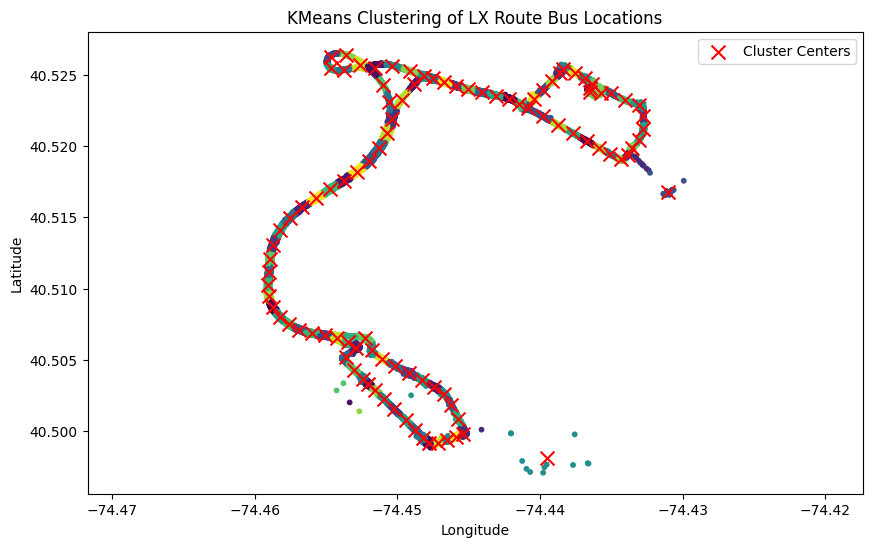

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.523818 -74.436469
1   40.525312 -74.454611
2   40.522023 -74.463525
3   40.524107 -74.445479
4   40.523481 -74.457959
..        ...        ...
95  40.524460 -74.458521
96  40.520907 -74.437711
97  40.522210 -74.450532
98  40.516688 -74.458564
99  40.525392 -74.438393

[100 rows x 2 columns]


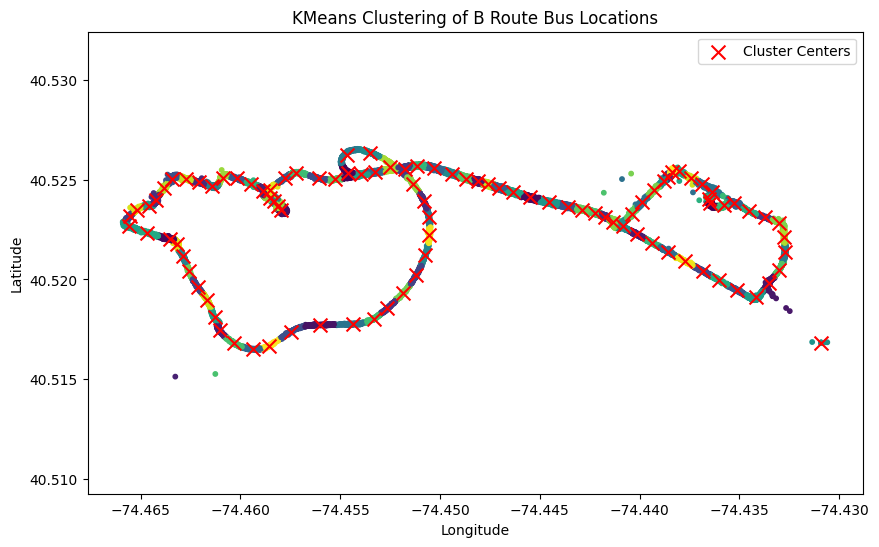

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.509483 -74.459000
1   40.485988 -74.438242
2   40.521887 -74.463258
3   40.500802 -74.442513
4   40.516308 -74.455908
..        ...        ...
95  40.508592 -74.458652
96  40.497689 -74.437054
97  40.507018 -74.456505
98  40.522808 -74.465754
99  40.482715 -74.438193

[100 rows x 2 columns]


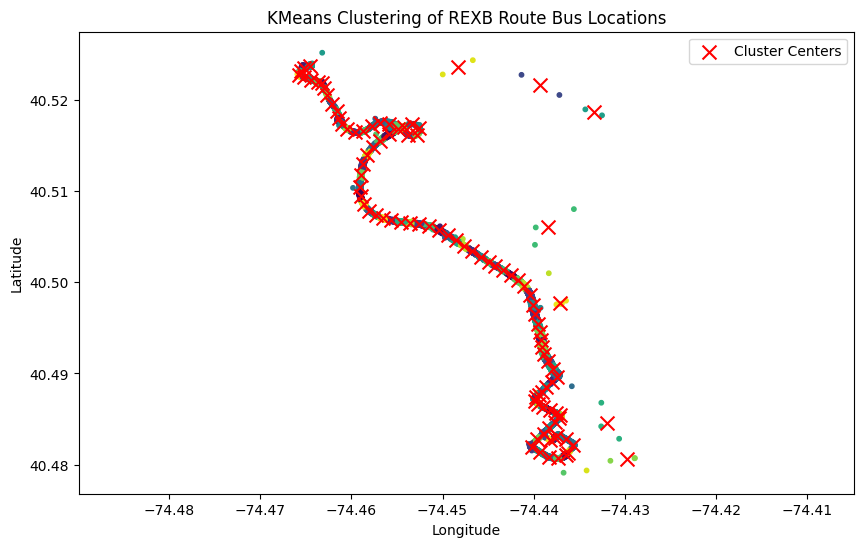

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.492301 -74.443082
1   40.479844 -74.433542
2   40.503616 -74.452348
3   40.483046 -74.437486
4   40.499388 -74.446532
..        ...        ...
95  40.499433 -74.448078
96  40.505619 -74.453102
97  40.508575 -74.458395
98  40.505596 -74.451787
99  40.489631 -74.441555

[100 rows x 2 columns]


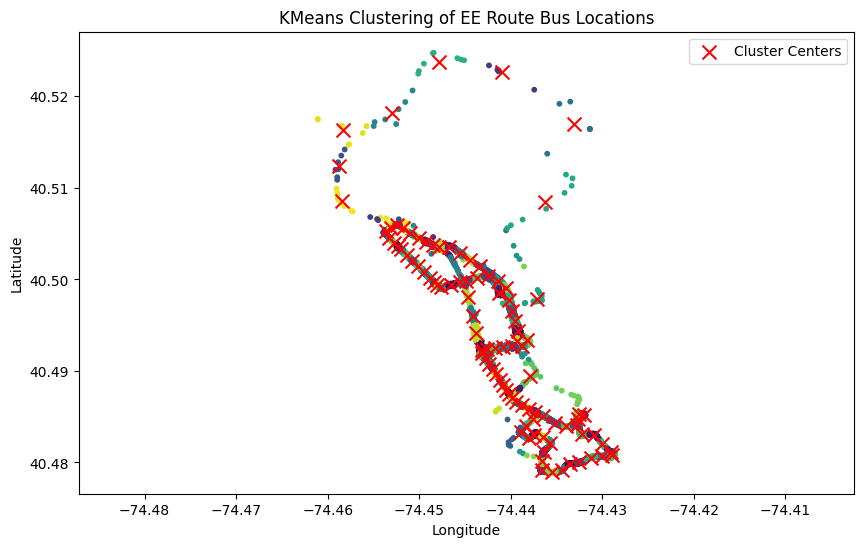

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.505900 -74.452945
1   40.521061 -74.462852
2   40.503406 -74.447887
3   40.523539 -74.458032
4   40.513867 -74.458358
..        ...        ...
95  40.503088 -74.447331
96  40.518212 -74.460542
97  40.502149 -74.446382
98  40.524239 -74.458763
99  40.516195 -74.452890

[100 rows x 2 columns]


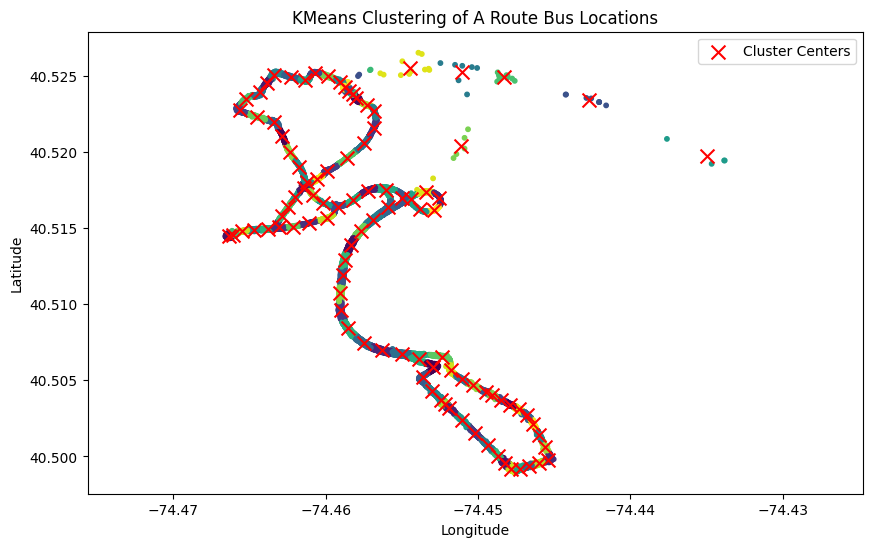

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.494633 -74.439350
1   40.520955 -74.437786
2   40.483071 -74.437479
3   40.516283 -74.455788
4   40.524487 -74.448665
..        ...        ...
95  40.522927 -74.433189
96  40.488046 -74.439066
97  40.519665 -74.435487
98  40.519610 -74.433667
99  40.507028 -74.456527

[100 rows x 2 columns]


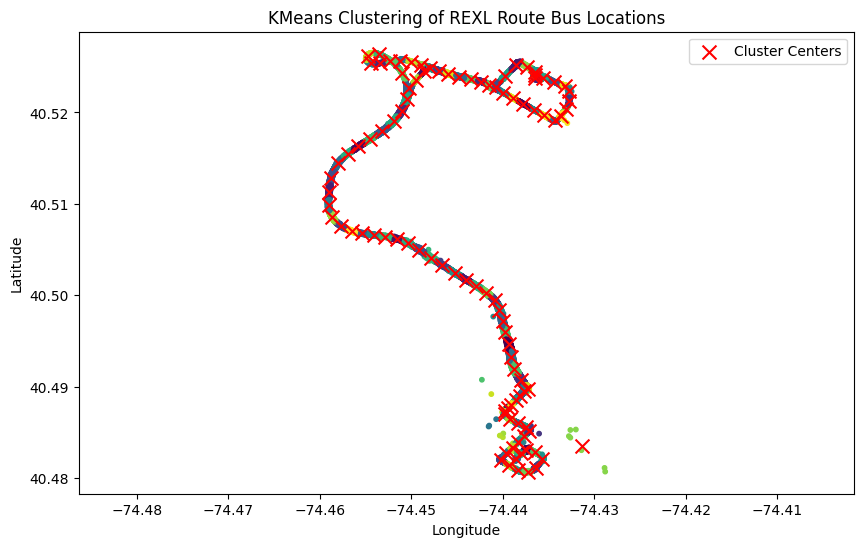

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.507221 -74.457050
1   40.523635 -74.458087
2   40.503118 -74.447378
3   40.516698 -74.458436
4   40.521894 -74.463297
..        ...        ...
95  40.505180 -74.453682
96  40.516962 -74.462050
97  40.510935 -74.459019
98  40.512501 -74.458845
99  40.506708 -74.454986

[100 rows x 2 columns]


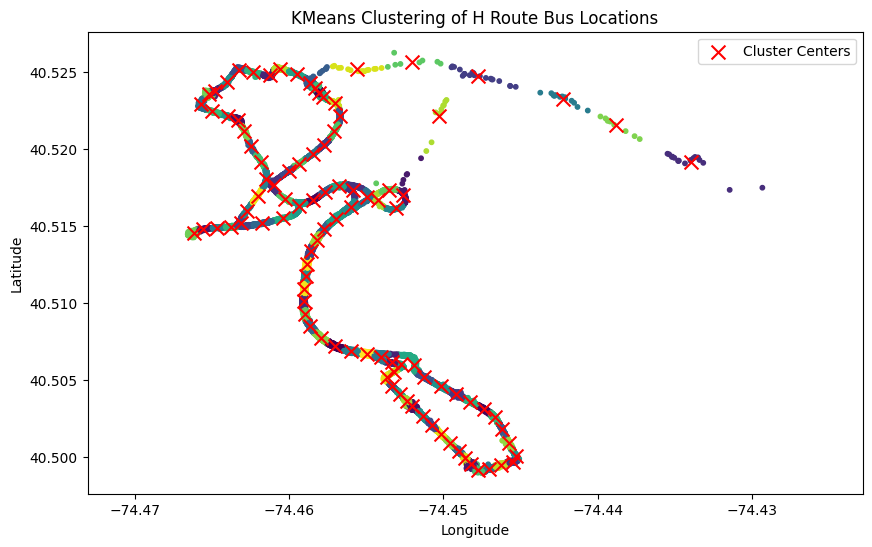

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.504654 -74.453379
1   40.488033 -74.439081
2   40.499780 -74.448437
3   40.482935 -74.437625
4   40.498145 -74.440363
..        ...        ...
95  40.483762 -74.438575
96  40.487376 -74.439781
97  40.501934 -74.446299
98  40.505323 -74.451462
99  40.502414 -74.444843

[100 rows x 2 columns]


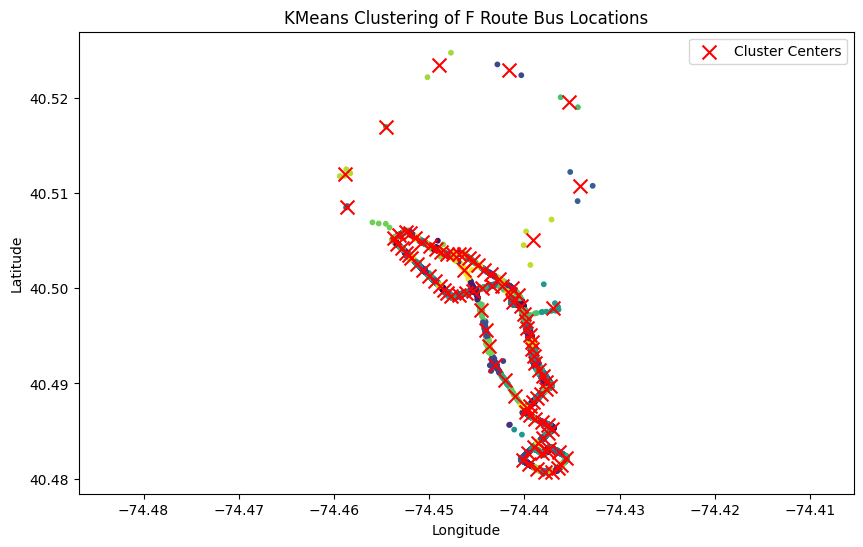

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.525160 -74.456376
1   40.524284 -74.436405
2   40.523559 -74.465215
3   40.524566 -74.447050
4   40.517487 -74.457138
..        ...        ...
95  40.524868 -74.462066
96  40.523694 -74.464923
97  40.516051 -74.453006
98  40.523378 -74.457814
99  40.523842 -74.439904

[100 rows x 2 columns]


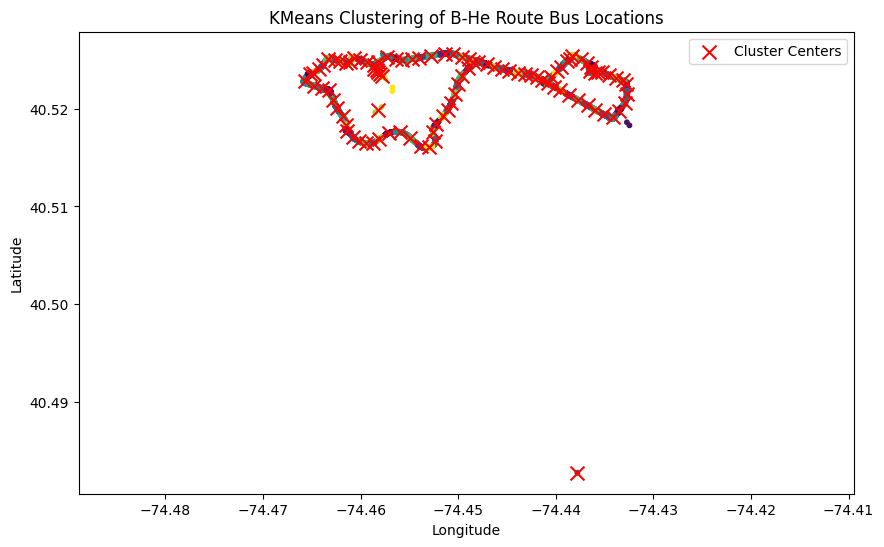

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.522944 -74.465741
1   40.515223 -74.463234
2   40.514523 -74.466102
3   40.521177 -74.462906
4   40.518663 -74.461525
..        ...        ...
95  40.514724 -74.465817
96  40.514962 -74.463556
97  40.522084 -74.463860
98  40.516801 -74.462162
99  40.519691 -74.462208

[100 rows x 2 columns]


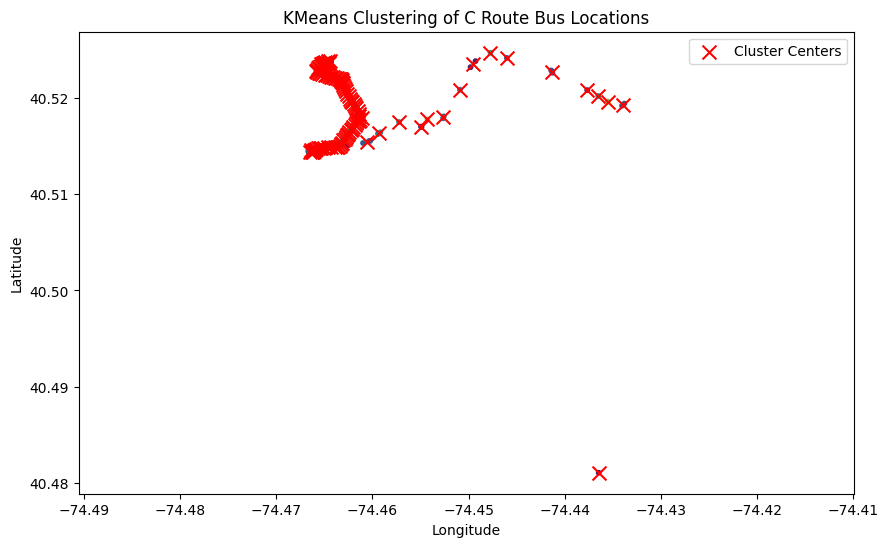

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.524784 -74.436855
1   40.488168 -74.444547
2   40.508465 -74.458568
3   40.523564 -74.458028
4   40.484045 -74.434393
..        ...        ...
95  40.516503 -74.455779
96  40.510252 -74.459043
97  40.491488 -74.442778
98  40.501954 -74.444187
99  40.520642 -74.462674

[100 rows x 2 columns]


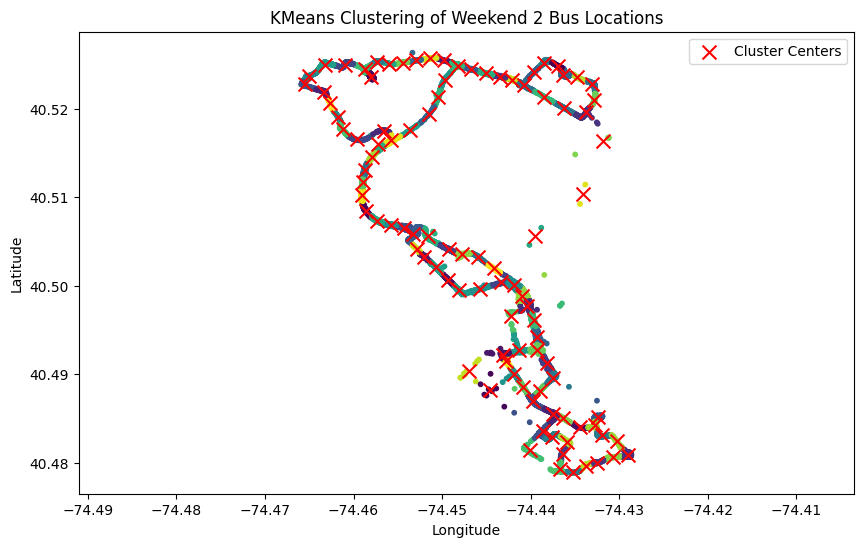

C:\Users\akash\AppData\Local\Temp\ipykernel_27592\2506450283.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bus['cluster'] = kmeans.labels_


     latitude  longitude
0   40.523569 -74.458038
1   40.493283 -74.438213
2   40.523922 -74.436479
3   40.504945 -74.450862
4   40.485198 -74.432332
..        ...        ...
95  40.480592 -74.430857
96  40.505968 -74.452614
97  40.504082 -74.452792
98  40.481386 -74.440001
99  40.495270 -74.439488

[100 rows x 2 columns]


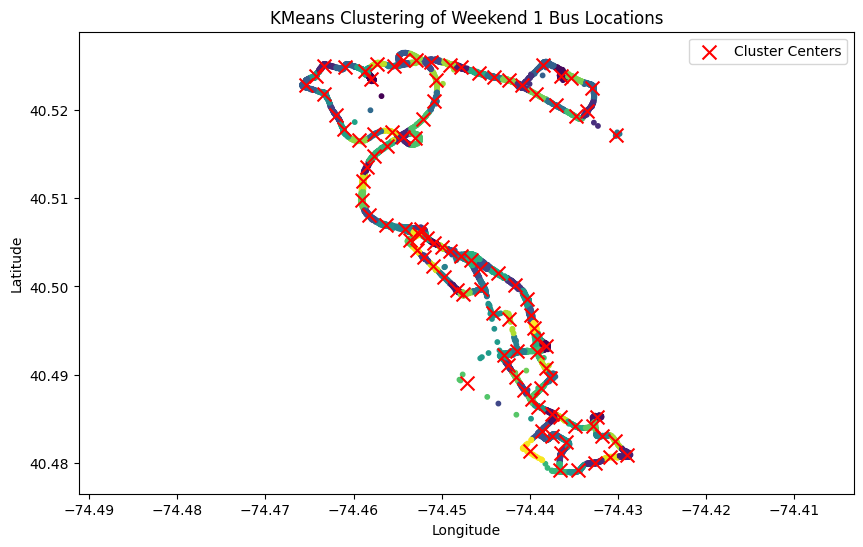

In [10]:
# prompt: make 30 clusters and show average position for points

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


for routeName in data['routeName'].unique():
    # Assuming 'data_bus' DataFrame from the previous code is available
    # get A Route data
    data_bus = data[data['routeName'] == routeName]

    # Prepare data for clustering
    X = data_bus[['latitude', 'longitude']]

    # Perform KMeans clustering with 30 clusters
    kmeans = KMeans(n_clusters=100, random_state=0).fit(X)

    # Get cluster labels for each data point
    data_bus['cluster'] = kmeans.labels_

    # Calculate the average position for each cluster
    average_positions = kmeans.cluster_centers_

    # store the cluster centers in a file with an id
    average_positions = pd.DataFrame(average_positions, columns=['latitude', 'longitude'])
    average_positions.to_csv(f'clusters/cluster_centers_{routeName}.csv', index=False)

    # Print the average positions
    print(average_positions)

    # Visualize clusters and average positions
    plt.figure(figsize=(10, 6))
    plt.scatter(data_bus['longitude'], data_bus['latitude'], c=data_bus['cluster'], cmap='viridis', s=10)
    plt.scatter(average_positions['longitude'], average_positions['latitude'], marker='x', s=100, c='red', label='Cluster Centers')
    plt.title(f'KMeans Clustering of {routeName} Bus Locations')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal')
    plt.legend()
    plt.show()

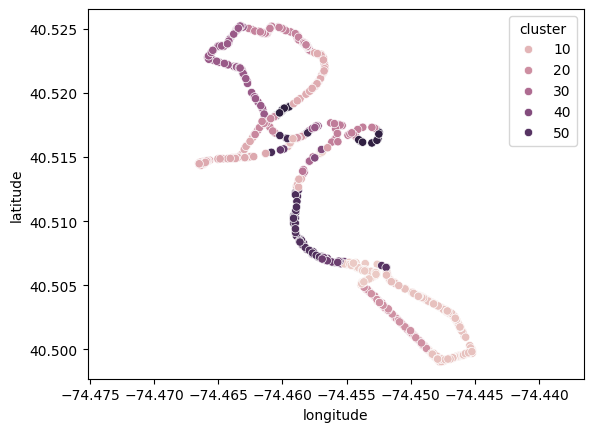

In [12]:
# get the data for a specific route
route = 'A Route'
data_route = data[data['routeName'] == route]

# limit the data to only 1000 rows
data_route = data_route.head(1000)

# read the cluster data for the route and create a new column with closest cluster
cluster_data = pd.read_csv('clusters/A Route.csv')

# for each row in data_route, find the closest cluster center
data_route['cluster'] = -1
for idx, row in data_route.iterrows():
    min_dist = np.inf
    closest_cluster = -1
    for idx2, row2 in cluster_data.iterrows():
        dist = np.sqrt((row['latitude'] - row2['latitude']) ** 2 + (row['longitude'] - row2['longitude']) ** 2)
        if dist < min_dist:
            min_dist = dist
            closest_cluster = idx2
    data_route.at[idx, 'cluster'] = closest_cluster

# plot the data_route with the cluster as the hue
sns.scatterplot(x='longitude', y='latitude', hue='cluster', data=data_route)
plt.axis('equal')
plt.show()

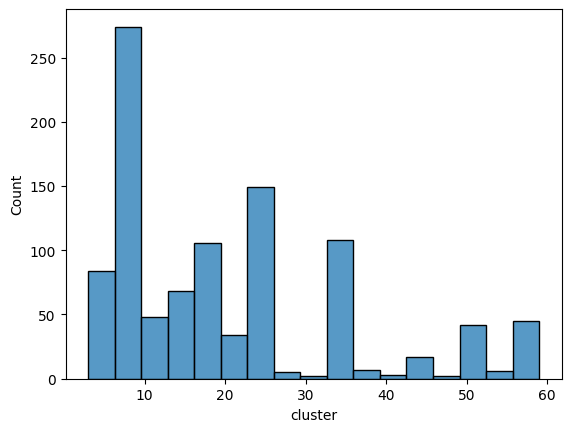

In [13]:
# show the distribution of the cluster
sns.histplot(data_route['cluster'])
plt.show()